## Part 1. Chatbot 

In [1]:
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
corpus_name = "cornell movie-dialogs corpus/"
corpus = os.path.join(corpus_name)

In [4]:
def printLines(file, n = 10):
    ### "rb" read binary file ###
    with open(file, "rb") as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

In [5]:
printLines(os.path.join(corpus, "movie_lines.txt"))

b'L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!\n'
b'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!\n'
b'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.\n'
b'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?\n'
b"L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.\n"
b'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow\n'
b"L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.\n"
b'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No\n'
b'L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?\n'
b'L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?\n'


In [6]:
### Both UTF-8 and ISO-8859-1 can be used to encode Unicode charactor
### but ISO-8859-1 (Latin-1) is a single-byte enconding that can represent the first 256 Unicode characters.
### Unicode is to cover all characters in all language
### https://stackoverflow.com/questions/2241348/what-is-unicode-utf-8-utf-16

In [7]:
for line in open(os.path.join(corpus, "movie_conversations.txt")):
    print(line)
    break

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']



### Create formatted data file

In [8]:
def loadLines(fileName, fields):
    '''
    Load lines from fileName, and get lines dir based on fields
    '''
    lines = {}
    with open(fileName, "r", encoding="ISO-8859-1") as f:
        for line in f:
            values = line.split(" +++$+++ ")
            lineObj = {}
            for i, field in enumerate(fields):
                lineObj[field] = values[i]
            lines[values[0]] = lineObj
            
    return lines

def loadConversations(fileName, lines, fields):
    '''
    Load conversation file using fileName, and get conversation dir based on 
    previous load lines and filed.
    '''
    conversations = []
    with open(fileName, "r", encoding="ISO-8859-1") as f:
        for line in f: 
            values = line.split(" +++$+++ ")
            convObj = {}
            for i, field in enumerate(fields):
                convObj[field] = values[i]
            lineIds = eval(convObj["utteranceIDs"])
            convObj["lines"] = [lines[lineId] for lineId in lineIds]
            conversations.append(convObj)
        
    return conversations

def extractSentencePairs(conversations):
    '''
    Extract the paris of conversation as inputLine and targetLine 
    '''
    qa_pairs = []
    for conversation in conversations:
        ### The last line can only be used as target ###
        for i in range(len(conversation["lines"]) - 1):
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i + 1]["text"].strip()
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    
    return qa_pairs
    

In [9]:
datafile = os.path.join(corpus, "formatted_movie_lines.txt")

delimiter = "\t"
### unicode_escape --> produce a string that is suitable as Unicode literal in Python source code ###
delimiter = str(codecs.decode(delimiter, "unicode_escape"))


In [10]:
lines = {}
conversations = {}
MOVIE_LINES_FIELDS = ["lineID", "characterID", "movieID", "character", "text"]
MOVIE_CONVERSATIONS_FIELDS = ["character1ID", "character2ID", "movieID", "utteranceIDs"]

In [11]:
print("\nProcessing corpus...")
lines = loadLines(os.path.join(corpus, "movie_lines.txt"), MOVIE_LINES_FIELDS)


Processing corpus...


In [18]:
print("\nProcessing conversations...")
conversations = loadConversations(os.path.join(corpus, "movie_conversations.txt"), lines, MOVIE_CONVERSATIONS_FIELDS)


Processing conversations...


In [14]:
conversations

[{'character1ID': 'u0',
  'character2ID': 'u2',
  'movieID': 'm0',
  'utteranceIDs': "['L194', 'L195', 'L196', 'L197']\n",
  'lines': [{'lineID': 'L194',
    'characterID': 'u0',
    'movieID': 'm0',
    'character': 'BIANCA',
    'text': 'Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\n'},
   {'lineID': 'L195',
    'characterID': 'u2',
    'movieID': 'm0',
    'character': 'CAMERON',
    'text': "Well, I thought we'd start with pronunciation, if that's okay with you.\n"},
   {'lineID': 'L196',
    'characterID': 'u0',
    'movieID': 'm0',
    'character': 'BIANCA',
    'text': 'Not the hacking and gagging and spitting part.  Please.\n'},
   {'lineID': 'L197',
    'characterID': 'u2',
    'movieID': 'm0',
    'character': 'CAMERON',
    'text': "Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?\n"}]},
 {'character1ID': 'u0',
  'character2ID': 'u2',
  'movieID': 'm0',
  'uttera

In [19]:
pairs = extractSentencePairs(conversations)

In [20]:
pairs[0]

['Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.',
 "Well, I thought we'd start with pronunciation, if that's okay with you."]

In [22]:
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for idx, pair in enumerate(extractSentencePairs(conversations)):
        writer.writerow(pair)
        if idx == 10000:
            break


Writing newly formatted file...


206

128

130

74

75

135

173

139

150

73

72

260

256

52

100

14

142

48

151

87

137

144

179

141

47

56

23

87

53

44

36

34

98

39

72

128

67

37

53

109

50

14

21

25

30

35

41

11

50

182

102

236

202

71

58

21

74

167

85

77

29

72

100

41

120

117

205

157

102

88

122

119

94

177

49

121

131

93

114

212

47

27

26

32

45

63

54

59

134

186

206

77

201

58

87

147

192

118

54

23

32

86

87

69

29

155

108

89

100

47

36

102

106

140

75

51

41

29

74

37

94

35

86

123

102

146

108

134

158

57

85

102

36

62

61

75

100

98

53

21

34

60

103

50

44

68

65

151

184

171

234

50

71

80

84

75

69

168

43

69

138

152

154

167

106

68

153

98

260

134

81

97

56

44

38

34

56

96

140

162

69

148

82

125

253

69

54

58

38

22

104

124

39

22

36

173

148

31

21

24

48

24

71

85

51

48

81

102

153

120

65

80

52

67

135

28

30

35

36

34

26

37

123

19

42

43

110

106

153

134

60

46

66

95

42

116

157

89

27

76

32

341

115

214

87

63

58

98

109

33

26

114

96

111

50

67

138

141

150

142

127

24

45

111

76

86

60

45

143

103

80

114

82

123

126

42

83

64

110

43

80

118

48

95

111

56

20

52

79

70

161

80

80

35

35

35

16

66

85

83

81

35

13

20

117

218

147

57

20

88

53

23

25

23

36

35

27

15

54

99

52

93

45

12

93

90

61

50

24

22

73

139

111

73

72

74

60

54

79

61

106

95

58

73

56

56

45

26

119

173

78

40

25

32

26

24

19

19

41

37

65

105

59

24

80

85

53

25

13

33

33

59

93

56

63

79

104

107

104

44

76

25

292

86

101

112

104

114

87

101

59

92

81

77

72

77

76

64

80

81

61

68

69

60

142

207

81

66

100

52

54

26

66

70

69

69

302

93

121

245

277

137

79

110

36

31

43

20

23

23

24

13

68

89

128

165

69

158

64

20

60

31

100

94

65

90

78

105

72

119

89

78

159

242

47

41

84

83

31

91

169

71

49

53

70

53

40

94

135

82

109

48

79

166

121

223

165

196

223

174

64

194

179

176

99

71

109

156

259

146

70

170

35

44

127

114

85

79

27

74

68

61

96

130

146

51

131

158

89

48

46

48

49

89

123

179

115

43

70

83

51

40

55

82

79

105

150

110

10

156

95

48

188

218

53

130

125

91

138

48

81

55

77

55

48

57

42

107

35

16

54

60

46

63

96

41

82

113

259

46

44

95

116

152

117

82

72

32

126

56

58

98

105

98

129

125

54

195

40

88

99

96

70

59

59

160

217

161

41

74

38

48

57

139

238

72

72

80

64

183

148

69

85

140

100

213

149

124

126

263

60

82

203

196

181

77

136

116

102

32

77

73

40

72

39

66

85

68

41

43

137

192

137

117

80

84

93

58

62

101

74

215

113

61

66

58

42

88

69

112

132

40

41

46

105

168

36

47

108

105

98

106

71

88

96

82

63

48

25

163

208

80

118

124

165

103

118

123

142

166

141

95

78

60

78

142

190

64

118

110

66

27

159

46

87

44

60

55

37

26

26

290

56

65

43

146

177

259

53

47

59

74

153

120

65

30

36

39

44

36

102

85

52

114

130

82

109

82

135

119

231

159

33

131

204

124

59

102

52

68

114

243

121

57

60

58

209

57

223

146

116

123

69

340

349

111

130

36

118

173

70

149

124

47

60

493

25

27

32

32

29

25

82

28

32

78

127

28

127

60

107

124

112

132

211

49

30

59

76

92

153

185

108

164

46

103

70

40

77

108

76

44

50

110

173

290

70

15

86

105

218

276

211

77

110

81

101

88

29

25

59

57

70

85

111

185

129

28

152

26

71

69

191

276

219

111

92

30

53

133

35

48

69

45

36

27

89

160

111

183

93

127

121

60

485

461

218

264

793

218

36

109

119

51

44

98

154

338

112

104

73

75

69

56

72

110

183

157

140

84

185

173

51

39

18

18

18

15

17

142

158

145

65

112

149

55

128

202

130

113

120

71

45

76

112

72

53

46

150

81

19

26

102

121

161

217

104

162

213

96

48

28

22

31

184

191

31

33

38

26

524

213

231

67

427

34

154

54

118

32

43

38

78

104

69

80

60

45

41

144

102

122

176

133

109

107

92

138

93

127

113

91

56

77

35

111

165

138

87

139

278

162

94

52

85

61

71

80

51

39

54

159

60

46

48

63

49

70

85

109

337

274

76

25

65

68

74

218

123

76

173

48

106

37

42

55

69

58

84

96

23

60

68

63

101

103

36

61

35

46

495

54

214

114

29

158

75

214

190

110

126

214

36

146

80

30

134

73

191

21

91

28

31

39

35

83

93

125

36

44

147

169

60

72

67

38

152

106

95

76

80

47

59

44

81

302

114

115

108

87

92

47

53

68

306

270

39

94

132

154

41

35

52

48

44

132

102

96

87

67

109

91

219

162

133

60

40

81

84

100

110

91

53

56

188

27

29

91

96

26

55

98

97

37

268

64

87

70

56

51

22

40

77

106

77

148

151

79

137

232

79

136

227

241

231

309

211

97

87

122

178

92

67

27

91

68

81

52

51

25

26

79

74

67

41

35

89

286

76

13

218

183

64

137

171

108

115

74

83

114

260

113

45

76

62

112

120

197

114

76

75

59

55

62

87

128

149

56

67

97

72

20

122

62

108

10

132

118

64

60

54

130

92

87

156

78

114

104

61

117

182

284

257

320

71

58

71

58

106

43

56

179

87

170

240

184

141

118

181

206

355

343

266

454

77

50

28

67

54

167

92

58

57

95

93

58

73

55

44

91

103

105

75

96

90

41

45

36

44

109

138

216

226

123

108

107

49

103

123

108

115

139

125

210

88

72

58

61

47

104

104

136

54

108

89

153

111

159

173

85

21

194

69

50

133

217

142

479

153

102

84

214

103

173

188

126

133

89

113

164

108

115

200

189

88

352

260

130

172

96

96

78

50

57

150

149

177

178

39

48

70

63

53

46

44

106

106

115

126

148

32

15

47

60

117

104

13

46

75

89

113

86

136

113

82

43

81

81

25

32

53

86

147

187

117

115

103

122

65

173

149

113

53

77

143

133

124

58

127

73

179

121

87

155

46

115

140

91

42

114

53

79

92

109

72

74

66

70

83

92

197

66

74

109

146

75

34

51

62

96

174

154

127

109

233

228

59

227

157

64

97

106

127

111

187

146

125

111

94

85

40

33

59

87

155

135

196

173

77

321

350

123

103

232

74

65

34

185

103

207

155

105

160

154

199

118

265

255

126

99

159

201

85

121

101

111

83

29

31

140

354

263

316

296

245

104

97

92

53

26

23

295

288

121

37

54

136

86

150

148

66

109

81

290

135

187

169

37

196

151

140

120

117

137

119

317

295

102

71

152

207

180

237

164

90

115

184

122

63

30

249

54

58

36

96

121

84

246

154

166

218

75

120

83

72

29

76

105

165

188

154

122

52

307

69

174

60

95

157

220

132

56

50

111

173

195

119

92

129

203

171

114

95

372

55

129

167

164

282

281

84

12

83

99

59

58

73

70

65

173

124

296

199

81

36

116

146

153

190

98

72

73

112

83

108

98

53

138

66

45

232

234

53

61

48

51

99

85

131

85

122

116

103

123

100

53

45

61

162

160

36

47

37

62

113

128

245

351

198

189

219

127

66

312

170

82

86

71

89

268

310

81

45

40

60

82

98

50

52

69

145

237

319

313

221

274

326

340

186

111

105

69

49

64

49

41

22

25

36

61

82

114

159

65

278

179

91

131

367

323

120

187

139

54

57

193

204

118

33

69

65

91

47

125

209

167

43

54

50

262

16

55

45

25

46

64

30

44

45

55

51

63

121

116

79

101

67

75

52

43

61

194

137

30

75

38

48

71

63

72

92

42

30

48

130

31

89

38

30

47

74

53

70

119

92

28

105

148

146

151

186

107

103

125

41

108

179

223

220

35

83

185

105

42

39

27

152

157

61

64

60

62

131

157

126

154

68

174

96

72

49

39

23

213

71

198

105

49

66

236

158

144

87

219

155

209

97

132

53

159

242

106

27

87

130

98

126

112

248

33

182

65

111

86

62

60

128

142

202

96

80

100

120

121

55

28

101

90

123

151

75

46

26

100

136

100

68

55

43

180

176

92

78

39

94

71

53

95

75

133

90

61

105

102

102

55

68

67

105

47

169

91

247

137

145

41

47

30

32

119

79

70

79

70

46

66

20

39

334

122

190

186

165

161

149

157

68

53

86

65

74

58

61

169

79

146

49

201

33

56

212

195

189

92

53

66

157

95

50

24

63

21

43

177

155

57

43

48

27

20

175

59

69

132

34

30

20

118

158

96

24

58

52

22

77

86

93

78

39

86

141

112

59

114

60

134

129

67

96

91

76

43

53

67

169

140

86

25

126

203

102

42

25

69

122

242

326

124

30

71

74

83

53

26

61

58

232

226

134

153

70

191

140

223

49

128

143

88

57

72

55

79

40

102

224

206

78

22

30

112

106

78

162

121

154

105

25

102

209

157

70

115

77

55

79

46

37

142

85

49

69

54

201

198

53

50

82

117

136

75

24

88

77

140

137

68

78

72

141

146

102

46

70

132

228

217

50

67

83

105

74

57

86

73

89

45

38

77

176

66

166

142

46

30

56

54

37

22

51

64

84

85

41

31

43

98

122

114

124

163

145

29

107

153

367

310

31

46

82

113

70

24

81

37

237

244

40

44

103

94

43

83

129

128

43

36

79

157

63

49

40

35

32

53

83

69

100

37

78

113

54

73

98

106

96

107

82

191

36

27

78

78

48

27

153

188

158

940

75

40

67

87

364

365

168

199

101

185

138

192

93

24

25

39

27

27

34

62

75

132

88

54

58

31

51

34

32

33

43

115

239

265

67

47

31

72

116

100

192

71

85

96

522

69

32

82

151

160

82

88

269

271

88

66

184

114

37

53

72

65

221

28

128

128

44

128

190

258

304

204

127

128

114

123

178

177

46

46

249

170

278

268

169

141

161

165

111

111

76

202

216

182

79

97

232

196

189

34

191

94

43

102

43

51

108

118

36

67

60

66

91

190

168

150

82

137

148

85

91

109

52

66

52

162

183

195

240

86

50

46

74

170

117

36

62

180

163

75

92

86

62

1358

186

185

614

608

94

146

1186

30

37

55

104

141

131

253

231

259

233

64

61

116

119

147

163

131

36

40

163

288

176

152

204

107

93

118

151

107

78

38

136

47

66

76

183

88

158

92

126

53

72

242

48

108

71

47

223

164

82

103

119

180

182

225

129

111

226

256

232

77

63

188

469

198

103

130

154

163

98

66

62

310

302

453

91

65

225

74

104

73

190

128

114

67

21

59

236

193

116

144

82

40

64

89

156

127

84

177

130

115

88

91

298

225

204

457

72

103

88

241

234

77

614

101

38

208

201

41

139

130

64

138

107

59

160

301

192

152

160

100

73

104

288

40

23

19

97

243

275

78

67

288

309

192

60

111

430

106

127

427

118

137

277

131

109

66

156

152

105

98

82

94

104

127

160

109

108

116

40

42

90

320

289

233

46

89

98

92

79

61

74

30

235

92

54

49

60

84

105

53

46

48

40

24

54

59

65

127

87

79

162

170

164

111

48

68

112

143

160

120

93

110

105

83

109

158

124

59

32

45

42

137

32

102

124

69

162

91

88

51

65

106

42

247

42

77

143

146

129

152

131

102

87

113

76

113

55

85

45

50

116

103

36

72

38

54

36

140

114

99

114

119

56

63

181

152

141

153

209

54

197

210

108

56

29

76

37

88

103

96

109

105

56

58

60

70

54

32

128

107

122

112

20

72

48

60

95

82

38

112

111

116

59

68

46

77

85

38

36

102

97

94

106

132

86

88

86

39

33

157

190

88

86

39

68

67

95

33

24

21

50

78

61

115

23

102

97

16

75

86

89

97

167

128

135

105

98

97

169

109

147

110

145

94

236

266

111

62

80

63

160

37

99

88

81

81

74

42

142

64

20

76

181

99

22

37

94

86

101

43

282

165

109

105

23

73

75

58

126

123

68

147

144

73

110

93

120

239

64

195

130

124

14

131

137

153

33

49

146

76

103

146

188

44

57

90

196

189

228

106

116

319

320

207

350

63

223

209

76

48

123

37

151

219

366

108

39

176

184

97

89

76

42

90

198

193

225

254

371

115

133

54

43

78

81

247

188

84

26

132

82

122

32

78

58

71

27

61

48

87

54

43

33

70

82

52

59

107

128

43

34

86

58

90

94

78

66

105

107

70

104

153

160

95

122

116

170

244

213

172

94

57

101

70

190

165

103

37

53

45

63

70

39

46

41

50

53

203

198

67

96

70

64

67

114

163

133

47

38

93

56

200

149

113

59

62

53

179

35

201

159

121

54

91

91

67

131

211

168

82

136

124

72

72

48

141

94

102

177

128

67

102

282

251

23

76

231

40

105

192

177

161

145

33

83

241

199

97

27

23

143

166

154

123

55

105

340

289

81

245

46

32

238

365

156

208

207

82

43

74

70

39

28

234

172

365

364

136

111

21

29

37

172

214

61

94

198

150

52

53

27

30

48

47

27

84

88

19

16

79

89

163

17

16

29

40

147

96

121

51

86

218

281

118

191

263

213

113

75

100

53

39

232

41

38

67

92

83

51

23

33

39

28

71

169

191

153

128

66

20

21

99

129

110

284

56

73

34

87

69

72

146

170

261

81

72

48

301

30

19

23

32

43

61

195

172

28

38

143

153

62

61

117

124

65

112

110

26

24

23

52

225

263

13

107

156

144

220

150

50

39

17

76

168

130

92

127

263

55

43

43

74

74

102

187

53

67

62

36

24

35

34

88

160

97

28

33

65

89

86

105

173

12

57

144

139

30

34

28

60

44

65

46

186

61

70

72

90

41

88

111

105

114

58

135

124

69

57

44

34

148

131

104

61

89

129

130

166

83

101

196

169

63

43

133

42

92

101

63

94

152

162

43

91

206

129

133

174

217

179

53

65

32

27

30

175

150

118

283

23

174

108

39

156

116

342

89

59

50

47

205

89

33

31

77

128

212

140

94

42

29

23

40

240

41

30

35

110

101

35

16

16

35

40

84

84

22

97

40

218

517

38

35

169

186

168

264

337

240

32

132

162

230

203

170

209

172

118

63

192

180

84

85

265

200

258

239

51

70

205

206

36

119

99

99

116

32

52

34

37

20

71

139

136

217

159

186

78

77

46

83

141

35

42

25

65

48

152

155

81

206

256

103

54

221

227

107

81

244

82

104

121

110

139

142

84

78

99

27

63

230

264

108

152

216

232

65

145

106

21

45

251

391

92

165

74

59

122

101

21

67

26

81

36

74

108

119

65

26

126

161

61

68

108

155

69

185

175

68

47

55

38

12

18

154

107

158

13

157

197

177

231

299

177

125

15

19

34

51

132

35

36

44

109

101

70

80

77

55

31

121

145

113

107

55

42

35

56

398

169

94

87

96

84

38

47

60

74

40

92

174

116

266

301

235

276

134

281

190

73

130

113

63

106

97

97

147

145

132

115

210

203

385

142

72

459

88

52

61

48

57

46

87

72

185

61

73

133

251

243

57

121

15

50

44

60

75

108

309

344

167

118

88

49

46

64

70

16

23

49

92

43

123

96

143

132

156

42

65

110

265

71

78

111

37

41

54

99

62

19

87

84

111

73

121

74

63

116

72

60

131

110

182

180

57

189

106

100

85

168

249

219

163

153

68

61

25

28

90

103

100

102

150

56

31

90

38

30

30

17

67

89

55

64

58

145

179

107

84

74

82

272

142

61

43

42

182

190

174

338

195

191

67

136

131

73

62

111

74

65

130

182

41

124

131

59

64

164

33

26

75

89

354

70

75

24

113

131

15

16

113

135

135

105

73

20

60

58

240

61

63

109

64

280

188

64

165

128

132

202

104

170

229

115

86

44

55

48

45

78

271

137

294

21

34

73

73

141

160

91

130

60

43

38

71

29

29

75

87

53

75

127

138

139

156

396

37

39

43

12

25

173

146

49

36

53

160

187

119

98

65

173

68

85

192

162

284

182

98

151

151

87

35

113

126

94

17

62

54

46

59

86

28

48

161

212

175

38

102

99

148

278

46

37

81

100

45

32

41

86

76

74

13

43

86

117

11

27

15

59

73

117

30

101

147

227

72

277

77

93

195

319

62

89

99

76

42

95

22

22

98

118

97

223

108

75

71

82

118

94

152

169

13

30

58

134

50

51

253

142

104

119

111

48

66

130

44

98

60

10

14

74

270

122

72

120

133

84

89

68

95

183

250

188

62

56

63

181

54

98

50

28

63

143

141

86

133

91

36

123

96

141

44

79

85

110

61

53

53

31

98

77

67

59

31

93

81

143

196

266

106

92

100

131

112

172

70

24

22

22

22

60

231

217

103

142

128

27

105

135

111

104

111

23

97

66

68

77

74

60

101

50

40

29

115

75

37

85

158

106

136

79

118

69

73

151

129

103

59

78

93

83

102

45

69

98

117

150

159

62

106

76

69

87

138

112

127

112

138

141

93

147

79

80

93

121

125

126

120

184

230

98

104

42

63

82

209

257

339

160

167

186

236

277

193

121

134

149

217

123

193

158

161

115

52

68

114

246

257

141

106

123

107

103

334

353

45

58

80

196

127

84

97

104

135

133

120

77

75

31

171

84

82

78

176

180

229

13

120

157

166

206

130

166

129

101

123

248

142

201

132

63

87

117

153

75

32

191

329

118

72

195

181

111

95

189

166

102

24

36

58

132

67

147

135

12

52

99

70

26

26

77

83

54

107

67

37

78

110

79

47

71

71

103

46

92

215

279

97

136

82

34

59

44

212

140

249

178

151

112

117

123

15

44

76

60

52

71

76

170

138

113

160

12

12

70

82

109

24

53

75

98

82

56

67

85

109

276

115

114

200

138

160

123

220

103

381

310

81

18

33

84

92

90

132

19

120

102

150

224

86

107

25

88

175

115

267

91

119

71

70

178

22

13

178

303

259

336

98

277

109

129

108

91

184

275

269

80

387

158

254

273

104

40

18

54

188

32

57

61

143

161

429

345

100

76

184

197

87

71

93

146

36

215

387

38

65

33

28

26

43

42

239

53

103

151

215

214

220

56

119

165

153

164

85

55

48

88

169

85

45

33

74

187

128

220

317

251

34

143

561

278

74

125

93

125

50

61

19

34

76

61

109

30

207

208

250

156

246

254

74

147

157

34

67

229

254

201

132

329

88

144

60

171

232

120

13

350

87

51

34

37

225

227

125

77

136

112

74

35

84

97

102

107

101

182

94

154

130

155

186

125

276

328

57

308

136

77

105

25

205

143

88

145

119

239

234

46

96

143

135

178

95

107

110

78

143

26

231

223

39

171

163

215

275

152

197

70

62

80

91

40

58

114

107

72

117

20

27

37

57

123

70

146

107

65

155

261

117

93

301

281

339

311

260

65

173

126

15

144

186

62

44

48

63

132

41

156

88

125

139

244

210

103

131

122

36

121

221

80

59

62

139

212

130

167

217

173

169

175

150

113

148

116

184

130

201

65

250

164

118

53

90

74

110

240

189

248

180

149

260

99

220

214

196

53

77

111

123

69

90

62

79

26

30

49

54

59

60

84

78

84

17

38

47

85

163

80

241

59

66

65

119

81

22

64

164

111

68

191

27

46

69

32

148

84

175

291

45

71

149

35

126

240

93

151

92

184

155

70

140

20

110

53

29

64

83

30

177

119

160

49

105

172

80

117

249

137

25

151

108

86

131

185

112

121

36

115

110

56

62

118

144

387

284

92

32

65

96

94

84

91

45

40

115

71

72

71

29

33

88

136

129

51

68

96

94

94

65

87

112

100

53

47

35

20

21

115

45

61

61

29

79

71

52

69

46

41

28

48

119

195

390

147

214

223

51

44

497

437

395

395

403

64

64

68

94

52

23

122

170

97

68

91

63

29

28

21

94

86

52

50

19

25

24

15

23

87

187

57

51

32

59

127

35

20

48

93

47

51

51

46

210

20

20

34

56

56

33

27

118

140

143

124

237

376

153

60

288

269

127

115

73

95

92

107

193

244

233

61

66

106

147

195

26

21

36

34

10

10

44

67

99

68

63

63

69

148

78

125

131

43

55

88

44

60

99

140

91

49

70

43

68

171

121

82

33

20

18

9

18

78

59

105

125

96

92

108

109

42

32

107

97

76

101

82

189

79

45

44

31

9

29

189

105

172

140

44

102

53

34

29

71

66

182

108

107

21

49

284

277

34

27

96

54

90

77

98

139

123

110

114

22

24

100

30

32

26

137

95

55

27

26

175

40

175

210

73

39

181

192

192

89

81

98

55

37

386

187

240

153

16

55

57

98

28

16

17

55

63

36

103

90

89

150

87

71

24

58

63

80

81

42

67

108

138

125

41

32

78

92

130

63

67

78

179

181

73

44

109

38

26

40

169

135

132

110

79

73

24

25

16

10

16

107

126

127

117

125

20

36

75

86

181

237

22

55

33

116

46

37

80

129

281

64

45

23

108

134

24

111

123

126

177

87

107

41

52

73

106

122

243

252

57

25

167

127

132

127

72

97

90

103

100

65

110

103

408

66

96

207

55

64

130

53

48

89

50

47

25

57

100

159

128

117

258

211

70

153

44

93

72

65

196

202

103

70

87

79

77

49

59

492

291

78

521

521

105

130

125

127

128

221

233

136

29

65

49

32

43

263

36

81

171

47

246

124

118

128

56

47

110

111

73

77

37

13

10

15

133

163

55

42

38

24

47

106

82

86

174

39

108

92

31

90

80

56

73

59

326

68

63

87

67

33

52

53

53

76

187

164

64

169

55

35

109

80

153

144

43

35

55

63

163

163

80

79

95

109

26

35

110

102

93

140

32

43

115

32

76

75

49

307

598

540

146

168

59

151

135

25

20

27

57

111

74

46

45

19

18

13

41

88

45

289

148

62

114

62

83

178

185

106

116

136

123

159

119

48

83

151

66

76

110

24

20

58

74

63

64

40

92

284

286

161

178

111

220

150

172

202

112

35

81

114

257

321

110

108

141

173

173

305

234

39

40

486

502

72

83

107

149

98

70

123

99

53

199

161

110

150

206

183

136

58

51

75

149

116

54

53

171

141

187

214

90

97

218

217

205

177

65

59

53

41

54

35

53

64

82

52

32

45

77

66

74

71

106

104

109

65

75

75

87

72

52

76

97

134

125

24

102

109

43

36

35

37

23

25

30

111

33

128

75

82

111

72

144

221

117

71

187

162

50

28

52

55

18

28

44

26

33

21

24

163

184

191

26

144

102

162

65

58

33

106

91

28

21

162

153

61

27

44

29

21

79

56

88

105

93

68

38

27

97

139

141

29

59

127

110

63

94

148

86

102

171

81

95

46

122

139

61

47

68

100

71

62

66

99

130

66

217

217

158

277

184

78

92

329

45

293

566

528

422

105

99

74

66

39

53

67

65

53

91

113

69

71

88

138

146

78

50

23

41

127

39

193

139

125

75

51

51

36

31

29

67

623

58

301

48

223

476

314

95

134

190

531

530

206

91

23

37

39

50

127

463

392

461

82

54

58

29

42

38

22

51

33

19

48

50

30

39

93

118

69

38

82

173

96

243

220

50

82

119

151

34

44

75

203

155

251

452

264

196

75

54

62

53

116

133

43

45

53

57

103

123

51

134

129

26

76

146

76

42

54

103

174

119

124

45

34

35

29

43

46

68

75

191

211

42

75

152

41

70

63

122

107

43

22

52

45

70

435

380

143

153

155

124

348

328

152

158

92

66

99

69

114

167

87

36

43

64

234

223

65

86

54

46

48

37

98

45

40

34

21

14

18

35

62

70

70

80

61

152

178

46

38

32

62

53

93

62

63

57

56

90

77

63

50

64

73

59

59

31

32

26

44

71

72

58

44

177

166

370

47

66

90

69

118

206

131

29

99

170

102

100

101

68

158

155

60

94

28

58

95

53

98

197

144

40

47

24

18

20

18

21

36

91

44

11

48

54

17

160

47

36

60

61

35

60

88

70

76

72

69

37

49

52

53

92

122

133

222

57

56

107

18

72

58

88

88

106

39

44

71

72

46

131

72

21

13

13

59

59

20

112

112

11

32

13

13

74

74

19

59

149

135

51

50

40

100

29

153

163

196

186

61

75

86

133

114

104

87

110

151

186

255

123

103

90

68

63

50

153

77

56

88

95

84

53

74

165

167

50

56

42

90

44

77

104

121

127

95

92

76

276

274

134

36

205

238

119

89

141

93

141

189

71

93

160

106

165

281

176

232

96

19

11

13

46

101

70

55

97

132

86

53

102

107

58

258

286

114

148

126

135

119

127

127

130

141

82

152

133

36

16

24

56

50

41

59

49

167

241

95

14

31

54

45

102

85

40

173

159

45

69

135

99

33

27

32

16

47

68

43

25

38

54

66

49

50

39

62

31

23

31

46

82

40

67

18

45

12

26

53

62

65

49

46

53

116

195

217

113

136

144

90

44

115

121

53

35

14

75

118

141

207

148

51

80

82

129

140

117

105

24

58

120

141

87

75

98

98

116

162

113

70

70

109

123

186

56

46

56

117

151

74

28

95

99

89

89

46

130

132

128

330

260

21

54

74

82

56

27

139

148

187

199

47

136

49

85

52

68

87

92

213

88

64

73

41

35

34

141

68

47

46

126

161

30

93

106

32

8

50

39

42

72

515

466

72

47

156

160

46

119

84

317

167

139

67

63

25

137

123

79

81

20

80

128

62

14

78

38

61

39

35

44

29

69

55

15

201

70

101

55

89

126

141

49

172

40

88

78

37

37

195

112

106

211

95

218

307

226

192

299

286

293

321

36

50

186

190

252

159

230

430

498

419

100

89

194

126

106

77

122

143

213

128

20

32

77

222

80

132

106

331

167

194

201

121

151

171

109

93

145

185

147

129

129

145

86

163

51

77

107

58

41

62

92

150

88

97

144

120

64

135

92

68

179

148

81

143

79

131

151

96

60

183

142

80

91

257

188

18

49

104

123

144

167

103

40

20

27

58

88

115

106

146

126

27

80

143

148

114

269

249

252

119

54

96

107

36

47

47

42

15

69

72

138

162

161

171

199

207

173

124

63

73

57

57

77

78

58

74

108

52

326

106

106

110

55

74

146

237

248

88

56

59

81

183

126

178

75

173

178

74

15

202

124

139

97

97

103

104

50

93

85

69

46

87

42

55

245

74

35

60

117

109

114

23

42

12

36

56

42

31

30

128

213

52

42

36

75

85

87

38

51

44

78

164

83

152

432

242

63

46

282

41

53

262

150

96

76

129

121

267

302

87

95

159

130

115

109

154

140

50

165

152

96

128

87

185

228

182

136

214

127

143

132

86

148

217

62

134

157

168

195

163

57

166

184

394

89

51

20

75

150

184

105

251

235

175

57

24

53

212

250

64

60

73

63

62

51

178

182

191

31

22

23

60

36

28

34

22

109

29

30

62

67

78

59

161

106

46

55

93

39

91

167

119

70

110

130

58

66

95

79

83

138

78

75

206

218

35

40

43

40

41

24

150

165

113

82

23

122

64

120

23

38

141

173

161

119

66

64

87

125

86

115

146

119

123

74

35

34

31

61

81

51

75

90

35

35

94

70

26

29

101

219

67

87

47

46

46

84

34

98

78

99

121

123

138

46

71

282

77

125

84

108

140

172

105

34

36

37

24

18

35

60

115

48

141

59

30

22

72

161

195

43

90

107

33

252

35

44

52

171

218

142

71

101

59

124

100

80

82

55

27

67

70

53

46

30

83

125

49

44

111

64

80

54

74

33

105

53

39

72

83

127

82

77

215

147

125

155

27

31

34

35

129

167

104

44

98

89

122

118

46

101

75

133

149

63

64

48

72

47

58

59

137

16

71

48

39

101

118

44

138

105

97

154

216

88

22

39

73

75

54

41

65

90

33

51

263

50

110

130

44

59

36

27

28

53

79

51

65

56

144

185

63

74

59

49

62

64

47

42

48

24

68

60

76

62

43

75

133

32

67

63

157

147

191

120

71

108

104

139

93

63

103

76

17

82

109

46

117

197

24

27

64

130

112

64

68

189

255

137

38

42

40

57

75

77

244

28

228

98

137

126

35

78

70

129

50

56

139

95

143

60

26

147

49

44

93

109

71

110

172

120

67

234

248

22

96

50

84

123

123

161

113

59

66

109

104

98

36

122

229

184

49

44

70

72

51

34

80

25

44

65

41

37

147

45

126

18

59

102

25

70

60

83

28

38

69

75

58

65

84

76

32

181

223

128

115

127

86

77

51

106

126

118

93

63

125

125

84

163

30

78

70

64

115

64

106

27

76

113

129

93

127

95

122

125

118

137

246

261

21

212

112

110

206

273

202

139

48

55

25

44

50

61

77

40

24

36

62

192

231

91

134

50

55

20

100

100

67

68

118

119

72

28

79

93

51

46

47

72

128

107

94

99

109

263

196

53

52

46

33

74

82

17

93

129

65

104

98

46

138

123

213

210

106

110

159

63

100

134

65

85

79

42

46

47

56

36

60

100

113

89

62

42

73

335

128

56

159

45

110

42

312

352

223

91

232

281

64

23

184

314

220

165

182

135

140

89

62

23

53

65

75

13

19

25

42

29

59

155

107

111

143

127

57

287

333

328

223

401

341

63

242

355

111

73

214

225

60

17

215

103

109

112

97

59

40

58

155

149

37

109

144

104

119

80

14

39

42

64

73

71

113

77

27

30

36

21

36

174

167

30

19

106

148

54

149

188

157

155

18

21

27

287

71

134

24

28

39

49

46

77

78

40

18

150

266

90

45

80

65

29

96

105

44

123

122

45

14

14

63

67

95

81

169

125

71

42

107

70

60

104

61

185

40

37

22

36

39

52

114

110

112

115

88

68

46

29

37

54

55

52

53

68

50

68

149

72

88

149

225

248

224

46

46

63

44

108

55

115

90

39

29

45

440

58

79

55

92

41

73

104

76

105

113

28

55

38

30

43

113

114

76

99

40

142

80

94

67

48

102

389

420

142

297

289

191

192

121

67

44

91

44

138

76

68

26

55

62

227

206

44

37

71

59

42

83

95

331

105

66

84

63

47

157

39

114

185

489

50

99

90

83

44

20

58

78

73

65

94

99

168

126

101

75

48

55

52

102

94

43

118

145

128

70

17

32

44

30

122

73

58

63

72

68

95

112

68

53

21

23

64

55

31

84

29

120

20

56

64

56

83

104

72

60

120

94

68

57

43

46

43

114

126

122

144

249

41

29

55

269

280

223

203

106

28

24

127

167

40

19

56

115

162

188

132

45

41

48

41

29

117

145

69

45

56

77

38

22

55

75

44

43

43

32

55

106

86

56

37

57

71

82

43

95

207

151

183

116

169

152

104

65

21

121

125

183

27

29

92

82

41

124

28

16

181

109

58

141

72

110

105

70

116

106

117

394

242

189

58

202

118

128

98

97

143

106

22

39

39

44

52

33

70

145

155

65

45

61

75

24

62

73

66

52

82

85

25

45

36

30

53

33

22

46

94

79

50

124

142

114

64

38

41

37

39

149

138

44

59

156

70

38

53

118

100

58

70

52

21

210

208

74

76

309

370

117

34

40

134

170

164

121

117

97

34

70

66

184

113

64

92

82

69

35

79

136

103

176

170

121

60

163

73

38

48

96

88

58

79

352

103

187

141

146

157

73

94

157

103

42

110

164

104

119

101

91

153

113

26

29

68

82

27

38

38

52

62

50

44

46

121

459

45

45

86

88

137

40

75

57

57

96

97

112

120

46

30

23

23

139

203

87

64

97

85

165

77

65

65

59

58

63

92

130

164

86

148

75

102

97

186

122

144

219

28

113

112

30

32

68

88

181

214

193

85

92

40

77

38

87

99

52

285

236

186

68

104

219

178

42

37

78

83

128

167

108

106

53

74

109

225

180

180

49

90

97

134

151

35

50

42

171

145

296

253

187

157

98

101

78

51

149

225

232

321

211

56

194

219

70

35

77

18

119

30

73

206

201

66

96

37

244

20

67

100

119

88

199

204

121

147

37

50

39

91

36

50

19

42

43

52

60

115

144

62

122

201

115

251

46

97

384

441

121

59

59

100

41

48

72

70

77

131

221

172

140

110

72

42

216

226

86

134

120

128

102

35

81

82

35

56

38

59

91

144

138

166

141

143

105

157

133

47

64

24

69

62

145

89

162

208

42

51

88

241

212

183

255

411

118

168

84

45

72

105

75

305

42

123

69

57

42

41

56

31

179

237

40

49

150

124

33

63

49

39

126

112

118

64

35

52

41

20

517

558

125

316

407

54

250

75

87

47

204

323

77

82

75

78

109

50

45

34

27

35

24

62

62

18

166

31

32

210

180

191

228

138

98

84

66

59

60

170

320

42

38

57

89

204

46

30

158

24

33

42

60

131

111

64

95

74

142

281

94

80

87

36

202

186

116

93

54

78

71

46

130

51

51

160

141

267

271

105

52

38

187

14

93

103

104

102

91

152

136

196

137

175

176

217

224

522

25

126

122

258

288

180

217

133

95

113

98

38

113

117

78

104

39

60

331

123

42

118

210

139

209

202

33

101

158

117

73

54

218

201

169

180

91

78

104

60

58

40

19

99

53

91

94

42

88

279

73

83

134

137

47

44

34

239

307

105

83

87

82

81

72

70

143

120

118

131

138

174

224

202

118

201

51

33

127

138

150

208

143

60

49

32

42

144

156

73

99

100

108

73

92

210

161

170

144

43

128

24

73

45

36

68

176

168

164

59

23

68

27

47

126

213

199

54

26

55

171

186

115

251

221

239

282

81

30

29

23

17

40

109

119

90

132

267

238

104

170

117

73

69

78

112

232

215

41

23

17

20

352

41

23

17

280

54

85

62

36

23

128

143

52

37

17

23

275

330

92

29

52

50

15

63

207

305

228

74

89

172

138

126

42

24

20

229

99

83

144

61

23

52

56

87

163

138

25

297

127

88

66

49

59

139

206

258

524

806

424

223

166

103

86

324

265

137

153

332

287

576

551

96

114

106

30

30

32

217

233

47

69

125

176

238

27

27

72

113

108

402

188

248

151

98

54

70

134

119

211

78

64

70

44

54

48

53

67

318

302

54

109

142

77

46

89

72

54

16

48

84

35

27

82

170

384

70

52

438

506

161

124

73

57

52

111

195

159

162

203

283

152

96

131

127

41

19

84

178

307

106

43

158

212

83

44

49

46

45

49

22

158

177

98

77

345

355

154

139

64

97

120

72

69

28

115

113

44

34

66

55

17

68

69

59

301

293

102

125

125

156

177

84

54

54

69

118

120

47

146

167

174

79

138

125

52

72

78

256

222

93

96

93

126

147

149

41

65

164

95

98

21

200

239

42

169

138

69

229

279

204

351

173

17

33

57

63

158

159

191

99

113

139

225

66

66

74

114

370

378

113

112

62

112

67

93

205

221

155

151

157

196

131

125

69

61

27

27

108

139

99

598

626

417

159

133

46

21

27

27

57

23

58

256

147

142

141

96

91

61

67

263

122

108

77

84

47

230

241

77

126

57

29

164

84

47

103

132

48

114

141

120

100

148

156

133

23

21

20

23

22

22

25

27

27

23

20

21

22

22

23

39

124

88

199

255

17

41

60

37

202

50

54

42

28

36

47

65

75

47

196

51

140

61

71

42

28

141

151

35

71

104

75

171

111

147

60

60

53

149

185

69

200

68

47

126

118

92

59

70

52

79

157

57

45

90

85

133

162

79

44

88

104

70

71

129

72

100

78

98

88

99

114

160

162

325

348

262

138

30

31

68

71

92

79

81

101

163

137

91

103

91

89

98

123

65

121

130

30

89

97

70

74

39

114

100

137

60

68

131

133

139

115

163

87

73

71

147

194

124

130

92

23

154

126

86

80

200

81

65

47

156

166

113

116

110

114

120

114

125

210

181

82

74

70

84

118

104

109

26

69

87

61

75

95

36

59

301

316

251

249

75

79

68

140

199

123

254

63

123

51

92

73

88

78

28

150

145

62

85

25

20

30

42

47

55

74

100

111

55

40

42

40

48

61

57

42

46

75

76

35

44

44

108

107

88

108

88

104

132

66

46

71

64

56

101

55

66

63

115

75

21

62

100

91

38

103

179

166

76

94

138

26

54

80

67

51

123

128

59

81

76

53

45

88

97

118

115

89

164

121

132

136

91

53

155

118

124

97

94

37

117

38

111

111

117

168

58

60

53

64

121

73

135

66

33

37

25

61

147

217

72

76

121

247

89

60

41

45

71

63

30

193

197

32

215

136

132

296

86

59

132

202

109

26

157

62

64

84

77

43

145

180

37

56

67

54

64

71

80

98

50

51

49

37

62

62

44

21

42

69

84

60

42

35

70

147

63

82

97

153

177

144

110

111

109

62

71

87

96

64

22

127

73

65

95

77

121

102

77

105

121

121

99

47

81

27

87

23

45

80

66

27

38

96

101

86

99

102

123

96

54

64

61

96

21

27

45

72

62

90

53

69

36

91

83

47

276

22

71

67

41

134

66

54

27

82

82

58

73

100

92

126

46

143

93

68

196

185

172

52

117

121

43

62

52

184

215

183

162

82

142

338

93

92

58

41

41

105

116

141

168

107

127

104

76

103

94

106

82

104

27

47

58

55

48

201

314

170

53

29

36

86

173

116

103

60

93

91

75

73

70

96

66

92

65

45

46

69

146

133

124

110

55

166

52

62

28

20

112

128

135

208

182

62

121

126

104

91

103

51

95

59

67

50

59

214

77

48

53

63

74

64

65

74

66

63

45

39

66

55

52

175

41

205

43

58

338

117

270

65

65

86

73

95

66

26

39

68

120

44

42

41

85

87

60

101

159

132

79

55

144

79

106

46

17

58

43

111

186

161

67

56

129

128

28

26

54

60

86

89

177

155

94

53

234

105

127

75

303

98

29

90

187

52

209

214

213

204

96

37

14

50

109

71

229

109

45

60

51

46

78

30

21

73

95

136

68

47

82

58

86

132

111

40

39

33

46

50

188

33

78

126

163

111

29

77

77

107

117

28

27

21

39

24

81

44

36

170

112

109

53

47

13

19

36

108

106

134

217

263

141

151

166

368

289

164

72

85

157

152

72

70

70

89

86

97

41

66

92

147

129

217

39

39

55

115

206

174

77

108

232

76

137

71

108

266

283

21

138

57

115

95

104

108

40

94

145

133

65

323

74

151

73

62

36

50

82

59

45

49

222

471

303

293

337

173

87

220

84

102

39

47

106

147

54

134

156

53

37

10

142

106

92

28

49

101

159

133

56

108

53

238

255

179

71

39

42

181

197

184

159

66

46

141

114

162

243

226

290

280

20

47

52

136

268

250

171

113

82

96

129

109

25

81

95

70

51

52

49

89

79

153

125

93

17

23

29

36

101

86

51

100

86

54

42

153

105

42

57

177

110

149

239

232

197

221

190

117

144

119

221

435

207

95

63

21

64

157

147

57

49

178

164

77

76

71

51

142

205

360

306

85

55

91

114

165

197

119

103

50

192

92

180

178

125

169

133

87

265

227

118

113

127

8

62

158

132

71

80

46

233

258

25

39

42

82

44

51

60

44

115

128

87

152

146

50

60

35

133

83

163

378

367

255

193

70

75

197

115

64

155

139

201

231

172

141

79

185

283

173

78

71

102

141

441

35

36

162

50

547

251

84

54

92

155

181

283

158

174

181

53

89

105

133

271

291

183

170

175

249

138

83

113

180

52

263

182

158

165

187

358

221

125

66

27

24

22

20

69

200

35

128

148

39

56

68

26

99

92

121

118

133

77

77

124

91

76

217

198

90

76

316

360

193

28

48

270

61

44

68

121

109

218

273

59

342

350

439

165

158

216

264

157

132

68

56

98

107

108

81

86

105

71

68

17

129

102

45

30

50

40

36

48

118

59

50

44

38

49

53

91

126

188

142

79

86

45

63

62

26

28

48

47

133

118

47

200

248

133

78

235

240

50

670

96

59

126

126

193

66

63

329

209

105

57

51

71

67

51

29

51

62

32

46

315

324

58

106

47

30

30

48

50

104

160

181

207

77

66

43

56

40

50

21

73

44

52

149

167

77

43

119

293

274

170

398

369

74

299

379

114

90

56

54

50

99

61

33

45

44

206

80

168

84

80

478

352

141

27

85

85

60

73

285

167

199

129

79

147

101

19

19

109

109

80

97

97

422

154

136

40

166

186

132

102

110

74

322

230

111

57

40

130

30

108

100

98

115

177

110

35

31

80

86

284

269

169

169

186

33

113

165

91

462

307

685

426

425

316

184

133

216

393

60

68

24

161

195

170

38

65

22

162

91

131

138

66

78

48

89

52

28

91

223

217

123

113

240

311

180

237

214

107

110

22

75

184

232

302

225

318

308

140

82

50

85

162

155

189

59

30

37

178

85

44

73

100

172

156

48

83

95

75

112

105

74

45

67

97

53

59

79

60

18

81

103

44

45

76

77

92

167

56

47

70

103

67

32

130

72

47

108

38

149

60

97

100

54

176

191

60

164

168

190

106

85

75

49

96

23

54

49

120

169

102

43

28

112

81

52

17

46

38

284

328

94

529

331

192

170

257

267

173

55

91

138

90

156

205

136

229

514

88

285

133

479

201

224

456

630

408

196

494

147

81

420

429

332

133

147

79

168

206

298

151

128

110

148

143

74

50

129

162

63

68

139

194

224

91

165

124

285

184

168

91

43

417

192

171

110

91

300

364

212

180

203

285

72

168

141

289

481

310

107

126

125

78

77

115

44

60

53

60

77

75

64

114

77

78

163

139

188

137

166

101

63

103

106

68

70

262

131

49

73

83

79

101

89

204

78

88

61

74

81

120

16

50

115

134

76

79

196

203

123

123

43

44

60

72

135

211

23

74

76

122

237

365

151

146

242

143

249

70

40

93

41

84

71

49

50

33

283

68

73

107

22

18

84

82

67

37

50

127

114

113

44

73

100

98

77

74

66

113

161

109

62

90

289

50

138

122

121

75

80

79

30

24

280

298

264

155

369

314

413

423

46

54

41

36

86

48

75

75

147

93

83

73

74

130

138

54

72

109

132

228

197

87

61

147

58

105

150

132

126

184

129

108

190

218

174

211

182

155

182

50

48

26

25

74

96

118

115

101

132

199

172

252

145

113

46

16

40

102

139

71

92

63

52

42

152

135

105

147

179

206

86

98

139

133

79

329

73

387

48

160

85

104

135

97

87

99

50

88

241

140

107

98

203

217

123

220

227

170

285

250

268

297

299

408

662

77

94

65

92

172

145

75

81

656

217

47

59

44

88

43

44

83

111

118

106

86

96

157

118

128

134

83

103

66

37

58

62

58

48

26

38

51

43

67

84

59

57

70

72

99

213

201

97

107

86

35

70

647

229

51

101

15

49

42

96

91

40

84

43

52

82

84

183

165

44

60

61

61

225

237

77

53

52

73

19

36

111

110

117

97

15

33

58

65

48

48

146

127

75

240

80

58

53

47

48

42

39

56

121

202

273

98

188

148

165

171

204

308

262

65

450

36

51

190

188

97

100

210

84

57

349

330

140

425

294

368

192

708

155

69

196

395

133

160

520

211

468

526

309

260

97

121

88

369

415

159

165

110

211

253

112

469

491

358

213

82

70

99

167

169

649

610

542

197

286

261

228

207

88

123

115

110

522

146

93

89

211

240

208

69

70

134

218

183

92

64

46

57

83

38

55

84

70

125

138

73

372

383

147

99

77

66

92

335

291

304

325

133

103

55

62

163

195

176

81

86

115

76

59

22

25

43

51

90

84

44

77

98

155

148

228

247

156

168

204

176

135

184

109

55

41

56

95

151

189

220

219

98

185

183

111

175

150

232

312

339

187

314

709

337

374

446

1297

46

90

96

41

58

245

185

305

232

252

358

341

159

103

184

275

226

88

42

62

80

83

80

311

85

319

34

594

131

107

101

92

84

53

429

267

277

210

91

211

639

683

439

342

277

308

111

47

492

483

593

109

124

93

49

37

11

176

262

106

70

39

131

669

515

117

99

580

454

72

100

289

457

200

839

359

292

262

286

45

37

83

144

104

70

106

94

76

193

163

113

61

55

89

140

136

20

72

54

205

212

50

53

28

69

66

96

152

64

92

108

84

57

70

50

109

94

81

38

110

34

106

99

72

76

45

124

111

259

46

110

65

126

26

92

121

176

110

50

41

83

86

206

130

48

36

34

28

119

120

44

406

41

115

113

42

35

42

108

77

144

123

259

143

80

73

134

88

76

91

24

110

41

38

80

119

197

174

301

49

228

43

57

54

224

55

51

101

184

41

74

41

89

24

58

79

128

59

40

37

15

86

78

81

140

155

31

24

147

171

85

102

75

27

22

31

62

46

148

85

65

52

54

155

144

95

42

86

209

312

61

182

337

79

148

188

301

345

247

217

104

53

35

138

44

83

166

68

47

115

118

109

111

283

313

155

261

69

133

331

123

75

53

53

101

87

109

32

25

23

26

98

118

78

91

165

395

263

185

211

220

101

107

95

160

97

77

86

109

115

160

168

198

148

80

76

87

44

43

232

212

71

55

26

239

78

208

57

81

93

74

178

297

285

68

59

100

238

299

310

154

158

207

453

298

179

125

172

98

75

35

70

125

133

88

90

193

199

168

164

396

In [10]:
print("\nSample lines from file:")
printLines(datafile)


Sample lines from file:
b"Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\tWell, I thought we'd start with pronunciation, if that's okay with you.\n"
b"Well, I thought we'd start with pronunciation, if that's okay with you.\tNot the hacking and gagging and spitting part.  Please.\n"
b"Not the hacking and gagging and spitting part.  Please.\tOkay... then how 'bout we try out some French cuisine.  Saturday?  Night?\n"
b"You're asking me out.  That's so cute. What's your name again?\tForget it.\n"
b"No, no, it's my fault -- we didn't have a proper introduction ---\tCameron.\n"
b"Cameron.\tThe thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.\n"
b"The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.\tSeems like she could get a date easy enough...\n"
b'Why?\tUnso

### Load and trim data

1. We will get the dictionary for word with word-to-index mapping.
2. We will get the pairs of input and target

In [11]:
### Default word tokens
### used for padding short sentences
PAD_token = 0
### used as start-of-setence token
SOS_token = 1
### used as end-of-setence token
EOS_token = 2

In [12]:
class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token:"PAD", SOS_token:"SOS", EOS_token:"EOS"}
        self.num_words = 3
    
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
            
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1
    
    def trim(self, min_count):
        '''
        Remove words below min_count 
        '''
        if self.trimmed:
            return 
        self.trimmed = True
        keep_words = []
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)
        print('keep words {}/{} = {:.4f}'.format(len(keep_words), len(self.word2index), len(keep_words)/len(self.word2index)))
        ### reinitialize the word dic after remove words ###
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token:"PAD", SOS_token:"SOS", EOS_token:"EOS"}
        self.num_words = 3
        
        for word in keep_words:
            self.addWord(word)

1. Convert the Unicode strings to ASCII
2. Convert all letters to lowercase and trim all non-letter characters except for baseic punctuation.
3. Filter our sentences with length greater than the MAX_LENGTH threshold.

In [13]:
### maximum length of sentences ###
MAX_LENGTH = 10

In [14]:
def unicodeToAscii(s):
    out = "".join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != "Mn")
    return out

In [15]:
def normalizeString(s):
    '''
    Lowercase, trim, and remove non-letter characters
    '''
    s = unicodeToAscii(s.lower().strip())
    ### for . ! and ?, insert space before them ###
    s = re.sub(r"([.!?])", r" \1", s)
    ### except a-z (lower case) A-z and . ! ?, replace all other letters using space ###
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    ### replace \t\n\r\f\v or any other delimeter using space ###
    s = re.sub(r"\s+", r" ", s).strip()
    return s

In [16]:
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    lines = open(datafile, encoding = "utf-8").read().strip().split("\n")
    pairs = [[normalizeString(s) for s in l.split("\t")] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

In [17]:
def filterPair(p):
    if len(p[0].split(" ")) < MAX_LENGTH and len(p[1].split(" ")) < MAX_LENGTH:
        return True
    else:
        return False

In [18]:
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [19]:
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data..")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs

In [20]:
save_dir = os.path.join("save")
voc,pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)

Start preparing training data..
Reading lines...
Read 10001 sentence pairs
Trimmed to 2770 sentence pairs
Counting words...
Counted words: 2808


In [171]:
print("\npairs:")
for pair in pairs[:20]:
    print(pair)


pairs:
['there .', 'where ?']
['hi .', 'looks like things worked out tonight huh ?']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['do you listen to this crap ?', 'what crap ?']
['what good stuff ?', 'the real you .']
['she okay ?', 'i hope so .']
['they do to !', 'they do not !']
['no .', 'you might wanna think about it']
['who ?', 'joey .']
['great', 'would you mind getting me a drink cameron ?']
['let go !', 'you set me up .']
['you set me up .', 'i just wanted']
['but she doesn t want to date .', 'exactly my point']
['daddy i', 'and where re you going ?']
['daddy no !', 'just for a minute']
['the prom ? kat has a date ?', 'no but']
['you the new guy ?', 'so they tell me . . .']
['how many people were in your old school ?', 'thirty two .']
['thirty two .', 'get out !']


#### Trim words that are rarely used
1. Trim words used under threshold using voc.trim function
2. Filter out pairs with trimmed words

In [22]:
MIN_COUNT = 3

In [23]:
def trimRareWords(voc, pairs, MIN_COUNT):
    voc.trim(MIN_COUNT)
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        target_sentence = pair[1]
        keep_input = True
        keep_target = True
        for word in input_sentence.split(" "):
            if word not in voc.word2index:
                keep_input = False
                break
        for word in target_sentence.split(" "):
            if word not in voc.word2index:
                keep_target = False
                break
        if keep_input and keep_target:
            keep_pairs.append(pair)
    
    print("Trimmed from {} pair to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs)/len(pairs)))
    
    return keep_pairs

In [24]:
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep words 960/2805 = 0.3422
Trimmed from 2770 pair to 1321, 0.4769 of total


### Prepare Data for Models

1. Input: convet English sentence to tensors by converting words to their indexes, and zero padded
2. output: except the similar tensors as input, it also needs a binary mask has same shape as the output target tensor, but every element that is a PAD_token is 0 and all others are 1. 
#### Note:
Instead of using shape (batch_size, max_length), we transpose and get the input batch shape as (max_length, batch_size)<br>
Thus, indexing across the first dimension returns a ${time step}$ across all sentences in the batch 

In [25]:
def indexesFromSentence(voc, sentence):
    indexes = [voc.word2index[word] for word in sentence.split(" ")] + [EOS_token]
    return indexes
    
def zeroPadding(l, fillvalue=PAD_token):
    ### use zero to padd the object if object is exhusted and not the longest object ###
    ### if input is [[1],[1,2],[1,2,3]] --> newlist is [(1,1,1),(0,2,2),(0,0,3)] ###
    ### thus, after zeroPadding, the matrix has been transpose ###
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value = PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    length = torch.tensor([len(indexes) for indexes in indexes_batch])
    ### zeroPadding also transpose the matrix ###
    padList = zeroPadding(indexes_batch)
    ### torch.LongTensor is a tensor type ###
    padVar = torch.LongTensor(padList)
    return padVar, length

def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    ### binary mask matrix ###
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

def batch2TrainData(voc, pair_batch):
    ### sort the list based on the length of first element of list, and shorter first ###
    pair_batch.sort(key=lambda x:len(x[0].split(" ")), reverse = True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


In [99]:
small_batch_size = 64
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, length, target_variable, mask, max_target_len = batches
print("input_variable:", input_variable)
print("length:",length)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)


input_variable: tensor([[ 31, 231, 536,  58,  39, 111, 851,  24, 111,  24,  24,   7, 411,  30,
           4, 102,  31,  62,  24,  89,  24,  24,   7,  69,   5, 129,  24,  46,
          26, 511,  26,  58, 688,   7, 307, 264, 182,  30,  61,   7,  33,  49,
          89, 318,  12,  49, 434, 736,  24, 129,  49, 304, 557,  31, 774, 242,
         948, 937, 147, 101,  89, 715, 254, 242],
        [ 42,   4,  12, 129,  90,   6,  26, 117,   7, 172,   8, 807, 118, 169,
           4,   3,  90,   7, 236,  43, 172, 172,  65,  34,  83,  34, 172,  83,
          83, 536,  13,   7,   4, 525,   7, 307, 152, 407, 163, 206,  34, 710,
          61, 369, 506, 574,  98,  46,  62, 420, 574, 771,  69, 447,   4,   4,
          60,   6,   4,   6,   6,   4,   4,   4],
        [102, 129, 115, 822, 450, 109, 394,  61, 377, 351, 265, 104,  20, 104,
           4,  12,  34,  17, 893,  59,  58, 342, 304,  68,  49,  55, 401,  24,
         876,   4,  61, 450,   4, 104, 907,   7, 183,  32,  35,  72,  69, 423,
           6,  

### Define Models

#### Seq2Seq Model

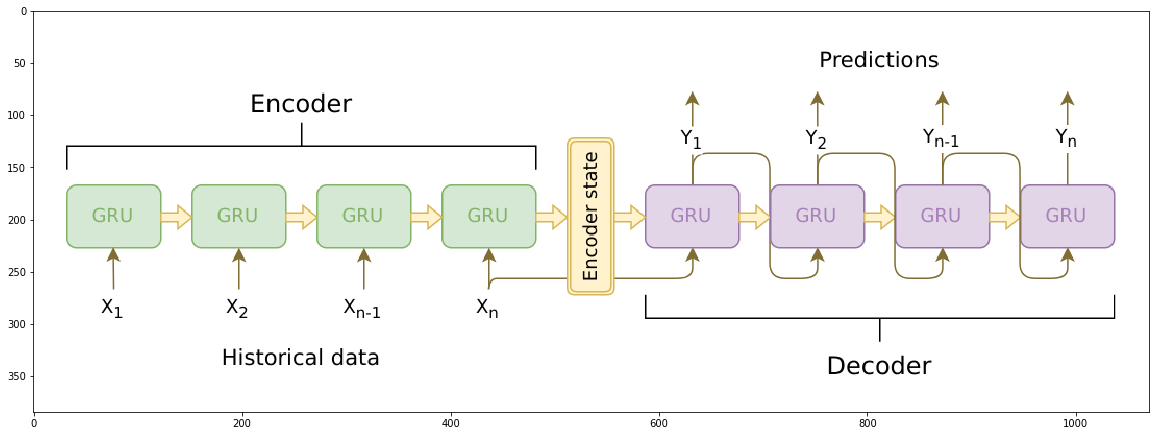

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("seq2seq_ts.png")
plt.figure(figsize=[20,20])
imgplot = plt.imshow(img)
plt.show();

### Encoder

#### Birirectional RNN

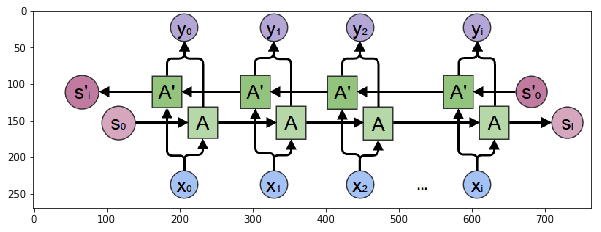

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("RNN-bidirectional.png")
plt.figure(figsize=[10,10])
imgplot = plt.imshow(img)
plt.show();

#### Computation Graph
1. Convert word indexes to embeddings --> initial embedding 
2. Pack padded batch of sequences for RNN module --> to do this packing thing can let RNN to know the elements that are not the padding, and the calculation will be only conducted on other letters, which is more efficient. 
3. Forward pass through GRU
4. Unpack padding
5. Sum bidirectional GRU outputs
6. Return output and final hidden state

In [29]:
class EncoderRNN(nn.Module):
    ### subclass nn.Module in defined new model, and all function in nn.Module can be used in new model ###
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding
        ### initialize the GRU ###
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout), bidirectional=True)
    
    def forward(self, input_seq, input_lengths, hidden = None):
        ### initial embedding ###
        embedded = self.embedding(input_seq)
        ### packing using the embedding and input_lengths, which is good for efficiency, especially for bidirectional RNN ###
        ### it also records the batch information for the packed elments ###
        ### example: initial --> [[1,1,2],[1,1,0]], packed --> [1,1,2,1,1] with batch size infor [3,2] ###
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        ### GRU ###
        ### the outputs includes hidden states at all time steps ###
        ### the hidden only includes the hidden state at time step = seq_length ###
        outputs, hidden = self.gru(packed, hidden)
        ### use zero to pad the outputs with variable length ###
        ### for each sequence, the length will become same as the longest one in the batch ###
        ### shape T times B times * ###
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        ### sum the bidirectional outputs ###
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, :, self.hidden_size:]
        return outputs, hidden
        

### Decoder

#### Global Attention

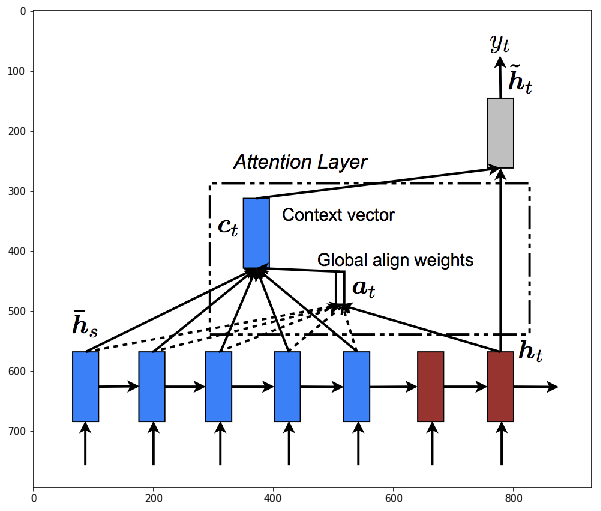

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("global_attn.png")
plt.figure(figsize=[10,10])
imgplot = plt.imshow(img)
plt.show();

We define our attention sub model first

In [31]:
class Attn(nn.Module):
    ### subclass nn.Module in defined new model, and all function in nn.Module can be used in new model ###
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        ### three different methods used to get the attention weights ###
        if self.method not in ["dot", "general", "concat"]:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == "general":
            self.attn = nn.Linear(self.hidden_size, self.hidden_size)
        elif self.method == "concat":
            self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))
        
    def dot_score(self, hidden, encoder_output):
        ### dim = 2 is to reduce the dimention in axis = 2 ###
        ### which is the embedding dimension here ###
        ### dot product between the hidden state and encoder output, which is same sa similarity measurement ###
        ### dot product is the inner product ###
        ### two inputs should have same shape ###
        return torch.sum(hidden * encoder_output, dim=2)
    
    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)
    
    def concat_score(self, hidden, encoder_output):
        ### hidden state of decoder should be first expanded and repeated ###
        ### thus, it can be concated with each output from encoder ###
        energy = self.attn(torch.cat(hidden.expand(encoder_output.shape[0], -1, -1), encoder_output)).tanh()
        return torch.sum(self.v * energy, dim=2)
    
    def forward(self, hidden, encoder_output):
        if self.method == "general":
            attn_energies = self.general_score(hidden, encoder_output)
        elif self.method == "concat":
            attn_energies = self.concat_score(hidden, encoder_output)
        elif self.method == "dot":
            attn_energies = self.dot_score(hidden, encoder_output)
            
        ### transpose max_length and batch_size dimensions ###
        ### from T * B --> B * T ###
        attn_energies = attn_energies.t()
        ### use softmax to normaliza the attention weightes for all letters ###
        ### unsqueeze is to add one dimension before axis = 1 ###
        ### final dimension is B * 1 * T 
        return F.softmax(attn_energies, dim=1).unsqueeze(1)
            

#### Computation Graph
1. Get embedding of current input word
2. Forward through undirectional GRU
3. Calculate attention weights from the current GRU output from (2)
4. Multiply attention weights to encoder outputs to get new "weighted sum" context vector
5. Concatenate weighted context vector and GRU output using Luong eq5.
6. Predict next word using Luong eq6 (without softmax)
7. Return output and final hidden state

In [86]:
class LuongAttnDecoderRNN(nn.Module):
    ### subclass nn.Module in defined new model, and all function in nn.Module can be used in new model ###
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()
        
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout = (0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.attn = Attn(attn_model, hidden_size)
        
    def forward(self, input_step, last_hidden, encoder_outputs):
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        rnn_output, hidden = self.gru(embedded, last_hidden)
        attn_weights = self.attn(rnn_output, encoder_outputs)
        ### batch matrix multiplication ###
        ### B * 1 * T matmul B * T * n --> B * 1 * n 
        context = attn_weights.bmm(encoder_outputs.transpose(0,1))
        ### get the attention weighted output ###
        ### squeeze the axis = 0, which is the time step dimension in rnn_output ###
        rnn_output = rnn_output.squeeze(0)
        ### squeeze the axis = 1, which is the middle dimension in context ###
        context = context.squeeze(1)
        ### use concation ###
        concat_input = torch.cat((rnn_output, context), 1)
        ### use linear transformation and tanh to get the result based on weight context and rnn_output ###
        concat_output = torch.tanh(self.concat(concat_input))
        ### get the final result ###
        ### one dense layer ###
        output = self.out(concat_output)
        ### one softmax layer, and get probability for each letter ###
        ### final shape: B * V ###
        output = F.softmax(output, dim = 1)
        return output, hidden
        

### Define Training Procedure

#### Masked loss
Only calculated the loss for the non-padding letters 

In [33]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    ### target.view returns the tensor with same data as target but in flatted version ###
    ### initial: [9, 5] --> [45, 1] ###
    ### torch.gather is to gather the probability of prediction in axis = 1 using word index ###
    ### exp. initial: [[0.4,0.6],[0.1,0.9] with dim = 1 and index = [1, 0] --> [[0.6],[0.1]] ###
    ### after squeeze --> [0.6, 0.1] ###
    ### note we use negative likelihood here to convert maximize into minimize ###
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1,1)).squeeze(1))
    ### select loss based on mask, where 1 is for non-padding letters and 0 is for zero-padding ###
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

#### Single training iteration

1. Teacher forcing: use the current target word as the decoder's next input rather than using the decoder's current guess. teacher_forcing_ratio is used to control the probablity our learning process is relied on the teacher force, which can avoid the fooling from fast convergence.
2. Gradient clipping: for exploding gradient problem. By clipping or thresholding gradients to a maximum value, we prevent the gradients from growing exponentially and either overflow, or overshoot steep cliffs in the cost function. 

#### Sequence of Operations
1. Forward pass entire input batch through encoder
2. Initialize decoder inputs as SOS_token, and hidden state as the encoder's final hidden state. --> here, use the hidden state from encoder
3. Forward input batch sequence through decoder one time step at a time
4. If teacher forcing: set next decoder input as the current target; else: set next decoder input as current decoder output.
5. Calculate and accumulate loss
6. Perform backpropagation
7. Clip gradients
8. Update encoder and decoder model parameters

#### Note: we need to manually run the GRN at one time step for decoder since we want to calculate each time step error(each letter error). This is not same as encoder.

In [116]:
def train(input_variable, lengths, target_variable, mask, max_target_len, 
         encoder, decoder, encoder_optimizer, decoder_optimizer,
         batch_size, clip, max_length=MAX_LENGTH):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    
    loss = 0
    print_losses = []
    n_totals = 0
    
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)
    
    decoder_hidden = encoder_hidden[:decoder.n_layers]
    ### trick one: teacher ratio ###
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            ### use target variable as the next decoder input ###
            ### view(1,-1), here -1 is inferred as other dimensions and 1 is the first dimension required ###
            decoder_input = target_variable[t].view(1, -1)
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            ### tensor.item() can only be used for scalar tensor ###
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            ### topk(1) returns the Top1 value and its index from decoder_output ###
            ### the index, which is the word index, can be used as the next decoder input ###
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            ### tensor.item() can only be used for scalar tensor ###
            print_losses.append(mask_loss.item() * n_Total)
            n_totals += nTotal
            
    loss.backward()
    ### trick two: use gradient clip ###
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return sum(print_losses) / n_totals      

#### Training iterations

#### Note: save a tarball containing all the information we need in future inference and continue running

In [113]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
              embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, 
              batch_size, print_every, save_every, clip, corpus_name, loadFilename):
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                       for _ in range(n_iteration)]
    print("Initializing...")
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint["iteration"] + 1
        
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        input_variable, lengths, target_variable, mask, max_target_len = training_batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                    decoder, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss
        if iteration % print_every == 0:
            print_loss_avg = print_loss/print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0
            
        if iteration * save_every == 0:
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                "iteration": iteration,
                ### use state_dict to save all parameters ###
                "en": encoder.state_dict(),
                "de": decoder.state_dict(),
                "en_opt": encoder_optimizer.state_dict(),
                "de_opt": decoder_optimizer.state_dict(),
                "loss":loss,
                ### use voc.__dict__ to save all the information in voc class as dict ###
                "voc_dict": voc.__dict__,
                "embedding": embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

### Run Model

#### Initialize the model

In [106]:
model_name = "cb_model"
attn_model = "dot"

hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

loadFilename = None
checkpoint_iter = 4000

if loadFilename:
    checkpoint = torch.load(loadFilename)
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']
    
print("Building encoder and decoder...")
### for each word letter, we first generate the embedding using the word index ###
### parameters in embedding can also be trained ###
### after initialization, if we load the previous trained model, we still need to load the corresponding weights ###
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
encoder = encoder.to(device)
decoder = decoder.to(device)
print("Models built and ready to go!")

Building encoder and decoder...
Models built and ready to go!


### Run Training 

In [117]:
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 4000
print_every = 1
save_every = 500

### Set the encoder and decode in train mode ###
### This is important for dropout ###
encoder.train()
decoder.train()

print("Build optimizers...")
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
          embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
          print_every, save_every, clip, corpus_name, loadFilename)

EncoderRNN(
  (embedding): Embedding(963, 500)
  (gru): GRU(500, 500, num_layers=2, dropout=0.1, bidirectional=True)
)

LuongAttnDecoderRNN(
  (embedding): Embedding(963, 500)
  (embedding_dropout): Dropout(p=0.1)
  (gru): GRU(500, 500, num_layers=2, dropout=0.1)
  (concat): Linear(in_features=1000, out_features=500, bias=True)
  (out): Linear(in_features=500, out_features=963, bias=True)
  (attn): Attn()
)

Build optimizers...
Starting Training!
Initializing...
Training...
Iteration: 1; Percent complete: 0.0%; Average loss: 6.8630
Iteration: 2; Percent complete: 0.1%; Average loss: 6.7597
Iteration: 3; Percent complete: 0.1%; Average loss: 6.5870
Iteration: 4; Percent complete: 0.1%; Average loss: 6.3197
Iteration: 5; Percent complete: 0.1%; Average loss: 5.9705
Iteration: 6; Percent complete: 0.1%; Average loss: 5.6858
Iteration: 7; Percent complete: 0.2%; Average loss: 5.3461
Iteration: 8; Percent complete: 0.2%; Average loss: 5.6396
Iteration: 9; Percent complete: 0.2%; Average loss: 5.1921
Iteration: 10; Percent complete: 0.2%; Average loss: 4.9126
Iteration: 11; Percent complete: 0.3%; Average loss: 4.6495
Iteration: 12; Percent complete: 0.3%; Average loss: 4.8232
Iteration: 13; Percent complete: 0.3%; Average loss: 4.6530
Iteration: 14; Percent complete: 0.4%; Average loss: 4.4193
Iteration: 15; Percent complete: 0.4%; Average loss: 4.4944
Iteration: 16; Percent complete: 0.4%; Ave

Iteration: 136; Percent complete: 3.4%; Average loss: 3.3294
Iteration: 137; Percent complete: 3.4%; Average loss: 3.3197
Iteration: 138; Percent complete: 3.5%; Average loss: 3.4692
Iteration: 139; Percent complete: 3.5%; Average loss: 3.3305
Iteration: 140; Percent complete: 3.5%; Average loss: 3.1677
Iteration: 141; Percent complete: 3.5%; Average loss: 3.2222
Iteration: 142; Percent complete: 3.5%; Average loss: 3.1333
Iteration: 143; Percent complete: 3.6%; Average loss: 3.2544
Iteration: 144; Percent complete: 3.6%; Average loss: 3.2836
Iteration: 145; Percent complete: 3.6%; Average loss: 3.3781
Iteration: 146; Percent complete: 3.6%; Average loss: 3.5317
Iteration: 147; Percent complete: 3.7%; Average loss: 3.0400
Iteration: 148; Percent complete: 3.7%; Average loss: 3.4561
Iteration: 149; Percent complete: 3.7%; Average loss: 3.2724
Iteration: 150; Percent complete: 3.8%; Average loss: 3.3437
Iteration: 151; Percent complete: 3.8%; Average loss: 3.4256
Iteration: 152; Percent 

Iteration: 271; Percent complete: 6.8%; Average loss: 2.6035
Iteration: 272; Percent complete: 6.8%; Average loss: 2.3520
Iteration: 273; Percent complete: 6.8%; Average loss: 2.5220
Iteration: 274; Percent complete: 6.9%; Average loss: 2.4619
Iteration: 275; Percent complete: 6.9%; Average loss: 2.5550
Iteration: 276; Percent complete: 6.9%; Average loss: 2.3474
Iteration: 277; Percent complete: 6.9%; Average loss: 2.4634
Iteration: 278; Percent complete: 7.0%; Average loss: 2.4955
Iteration: 279; Percent complete: 7.0%; Average loss: 2.4001
Iteration: 280; Percent complete: 7.0%; Average loss: 2.3422
Iteration: 281; Percent complete: 7.0%; Average loss: 2.4906
Iteration: 282; Percent complete: 7.0%; Average loss: 2.3651
Iteration: 283; Percent complete: 7.1%; Average loss: 2.3316
Iteration: 284; Percent complete: 7.1%; Average loss: 2.3193
Iteration: 285; Percent complete: 7.1%; Average loss: 2.5063
Iteration: 286; Percent complete: 7.1%; Average loss: 2.5007
Iteration: 287; Percent 

Iteration: 406; Percent complete: 10.2%; Average loss: 1.5829
Iteration: 407; Percent complete: 10.2%; Average loss: 1.5635
Iteration: 408; Percent complete: 10.2%; Average loss: 1.6405
Iteration: 409; Percent complete: 10.2%; Average loss: 1.5578
Iteration: 410; Percent complete: 10.2%; Average loss: 1.6556
Iteration: 411; Percent complete: 10.3%; Average loss: 1.6387
Iteration: 412; Percent complete: 10.3%; Average loss: 1.5497
Iteration: 413; Percent complete: 10.3%; Average loss: 1.6507
Iteration: 414; Percent complete: 10.3%; Average loss: 1.7317
Iteration: 415; Percent complete: 10.4%; Average loss: 1.6156
Iteration: 416; Percent complete: 10.4%; Average loss: 1.4900
Iteration: 417; Percent complete: 10.4%; Average loss: 1.6114
Iteration: 418; Percent complete: 10.4%; Average loss: 1.4419
Iteration: 419; Percent complete: 10.5%; Average loss: 1.4944
Iteration: 420; Percent complete: 10.5%; Average loss: 1.4908
Iteration: 421; Percent complete: 10.5%; Average loss: 1.5776
Iteratio

Iteration: 539; Percent complete: 13.5%; Average loss: 0.8773
Iteration: 540; Percent complete: 13.5%; Average loss: 0.8948
Iteration: 541; Percent complete: 13.5%; Average loss: 0.8331
Iteration: 542; Percent complete: 13.6%; Average loss: 0.9261
Iteration: 543; Percent complete: 13.6%; Average loss: 0.8551
Iteration: 544; Percent complete: 13.6%; Average loss: 0.8425
Iteration: 545; Percent complete: 13.6%; Average loss: 0.9241
Iteration: 546; Percent complete: 13.7%; Average loss: 0.8911
Iteration: 547; Percent complete: 13.7%; Average loss: 0.9175
Iteration: 548; Percent complete: 13.7%; Average loss: 0.8918
Iteration: 549; Percent complete: 13.7%; Average loss: 0.8314
Iteration: 550; Percent complete: 13.8%; Average loss: 0.8906
Iteration: 551; Percent complete: 13.8%; Average loss: 0.7031
Iteration: 552; Percent complete: 13.8%; Average loss: 0.7954
Iteration: 553; Percent complete: 13.8%; Average loss: 0.8954
Iteration: 554; Percent complete: 13.9%; Average loss: 0.7796
Iteratio

Iteration: 672; Percent complete: 16.8%; Average loss: 0.4689
Iteration: 673; Percent complete: 16.8%; Average loss: 0.4300
Iteration: 674; Percent complete: 16.9%; Average loss: 0.3911
Iteration: 675; Percent complete: 16.9%; Average loss: 0.3824
Iteration: 676; Percent complete: 16.9%; Average loss: 0.3997
Iteration: 677; Percent complete: 16.9%; Average loss: 0.3681
Iteration: 678; Percent complete: 17.0%; Average loss: 0.4397
Iteration: 679; Percent complete: 17.0%; Average loss: 0.3918
Iteration: 680; Percent complete: 17.0%; Average loss: 0.4147
Iteration: 681; Percent complete: 17.0%; Average loss: 0.4346
Iteration: 682; Percent complete: 17.1%; Average loss: 0.4054
Iteration: 683; Percent complete: 17.1%; Average loss: 0.3858
Iteration: 684; Percent complete: 17.1%; Average loss: 0.3627
Iteration: 685; Percent complete: 17.1%; Average loss: 0.3632
Iteration: 686; Percent complete: 17.2%; Average loss: 0.3475
Iteration: 687; Percent complete: 17.2%; Average loss: 0.3608
Iteratio

Iteration: 805; Percent complete: 20.1%; Average loss: 0.2178
Iteration: 806; Percent complete: 20.2%; Average loss: 0.1834
Iteration: 807; Percent complete: 20.2%; Average loss: 0.2410
Iteration: 808; Percent complete: 20.2%; Average loss: 0.1728
Iteration: 809; Percent complete: 20.2%; Average loss: 0.1785
Iteration: 810; Percent complete: 20.2%; Average loss: 0.2431
Iteration: 811; Percent complete: 20.3%; Average loss: 0.2058
Iteration: 812; Percent complete: 20.3%; Average loss: 0.1834
Iteration: 813; Percent complete: 20.3%; Average loss: 0.1869
Iteration: 814; Percent complete: 20.3%; Average loss: 0.1742
Iteration: 815; Percent complete: 20.4%; Average loss: 0.1640
Iteration: 816; Percent complete: 20.4%; Average loss: 0.1798
Iteration: 817; Percent complete: 20.4%; Average loss: 0.1993
Iteration: 818; Percent complete: 20.4%; Average loss: 0.2259
Iteration: 819; Percent complete: 20.5%; Average loss: 0.1626
Iteration: 820; Percent complete: 20.5%; Average loss: 0.1620
Iteratio

Iteration: 938; Percent complete: 23.4%; Average loss: 0.1140
Iteration: 939; Percent complete: 23.5%; Average loss: 0.1354
Iteration: 940; Percent complete: 23.5%; Average loss: 0.1093
Iteration: 941; Percent complete: 23.5%; Average loss: 0.1340
Iteration: 942; Percent complete: 23.5%; Average loss: 0.1462
Iteration: 943; Percent complete: 23.6%; Average loss: 0.1500
Iteration: 944; Percent complete: 23.6%; Average loss: 0.1100
Iteration: 945; Percent complete: 23.6%; Average loss: 0.1279
Iteration: 946; Percent complete: 23.6%; Average loss: 0.0926
Iteration: 947; Percent complete: 23.7%; Average loss: 0.1505
Iteration: 948; Percent complete: 23.7%; Average loss: 0.1520
Iteration: 949; Percent complete: 23.7%; Average loss: 0.1556
Iteration: 950; Percent complete: 23.8%; Average loss: 0.1216
Iteration: 951; Percent complete: 23.8%; Average loss: 0.1605
Iteration: 952; Percent complete: 23.8%; Average loss: 0.1214
Iteration: 953; Percent complete: 23.8%; Average loss: 0.1197
Iteratio

Iteration: 1070; Percent complete: 26.8%; Average loss: 0.0876
Iteration: 1071; Percent complete: 26.8%; Average loss: 0.1279
Iteration: 1072; Percent complete: 26.8%; Average loss: 0.1073
Iteration: 1073; Percent complete: 26.8%; Average loss: 0.1106
Iteration: 1074; Percent complete: 26.9%; Average loss: 0.0863
Iteration: 1075; Percent complete: 26.9%; Average loss: 0.0863
Iteration: 1076; Percent complete: 26.9%; Average loss: 0.1059
Iteration: 1077; Percent complete: 26.9%; Average loss: 0.1149
Iteration: 1078; Percent complete: 27.0%; Average loss: 0.0890
Iteration: 1079; Percent complete: 27.0%; Average loss: 0.1195
Iteration: 1080; Percent complete: 27.0%; Average loss: 0.1130
Iteration: 1081; Percent complete: 27.0%; Average loss: 0.1089
Iteration: 1082; Percent complete: 27.1%; Average loss: 0.1153
Iteration: 1083; Percent complete: 27.1%; Average loss: 0.1283
Iteration: 1084; Percent complete: 27.1%; Average loss: 0.1095
Iteration: 1085; Percent complete: 27.1%; Average loss:

Iteration: 1201; Percent complete: 30.0%; Average loss: 0.0729
Iteration: 1202; Percent complete: 30.0%; Average loss: 0.1280
Iteration: 1203; Percent complete: 30.1%; Average loss: 0.0833
Iteration: 1204; Percent complete: 30.1%; Average loss: 0.0855
Iteration: 1205; Percent complete: 30.1%; Average loss: 0.0559
Iteration: 1206; Percent complete: 30.1%; Average loss: 0.0601
Iteration: 1207; Percent complete: 30.2%; Average loss: 0.0937
Iteration: 1208; Percent complete: 30.2%; Average loss: 0.0728
Iteration: 1209; Percent complete: 30.2%; Average loss: 0.1113
Iteration: 1210; Percent complete: 30.2%; Average loss: 0.0980
Iteration: 1211; Percent complete: 30.3%; Average loss: 0.0701
Iteration: 1212; Percent complete: 30.3%; Average loss: 0.0507
Iteration: 1213; Percent complete: 30.3%; Average loss: 0.0733
Iteration: 1214; Percent complete: 30.3%; Average loss: 0.0861
Iteration: 1215; Percent complete: 30.4%; Average loss: 0.0825
Iteration: 1216; Percent complete: 30.4%; Average loss:

Iteration: 1332; Percent complete: 33.3%; Average loss: 0.0785
Iteration: 1333; Percent complete: 33.3%; Average loss: 0.0786
Iteration: 1334; Percent complete: 33.4%; Average loss: 0.0792
Iteration: 1335; Percent complete: 33.4%; Average loss: 0.0915
Iteration: 1336; Percent complete: 33.4%; Average loss: 0.0566
Iteration: 1337; Percent complete: 33.4%; Average loss: 0.0803
Iteration: 1338; Percent complete: 33.5%; Average loss: 0.0644
Iteration: 1339; Percent complete: 33.5%; Average loss: 0.0680
Iteration: 1340; Percent complete: 33.5%; Average loss: 0.0910
Iteration: 1341; Percent complete: 33.5%; Average loss: 0.0643
Iteration: 1342; Percent complete: 33.6%; Average loss: 0.0615
Iteration: 1343; Percent complete: 33.6%; Average loss: 0.0901
Iteration: 1344; Percent complete: 33.6%; Average loss: 0.0954
Iteration: 1345; Percent complete: 33.6%; Average loss: 0.0674
Iteration: 1346; Percent complete: 33.7%; Average loss: 0.0686
Iteration: 1347; Percent complete: 33.7%; Average loss:

Iteration: 1463; Percent complete: 36.6%; Average loss: 0.0440
Iteration: 1464; Percent complete: 36.6%; Average loss: 0.0704
Iteration: 1465; Percent complete: 36.6%; Average loss: 0.0821
Iteration: 1466; Percent complete: 36.6%; Average loss: 0.1221
Iteration: 1467; Percent complete: 36.7%; Average loss: 0.1093
Iteration: 1468; Percent complete: 36.7%; Average loss: 0.0291
Iteration: 1469; Percent complete: 36.7%; Average loss: 0.0669
Iteration: 1470; Percent complete: 36.8%; Average loss: 0.0932
Iteration: 1471; Percent complete: 36.8%; Average loss: 0.0713
Iteration: 1472; Percent complete: 36.8%; Average loss: 0.0955
Iteration: 1473; Percent complete: 36.8%; Average loss: 0.0694
Iteration: 1474; Percent complete: 36.9%; Average loss: 0.0933
Iteration: 1475; Percent complete: 36.9%; Average loss: 0.0900
Iteration: 1476; Percent complete: 36.9%; Average loss: 0.1163
Iteration: 1477; Percent complete: 36.9%; Average loss: 0.0554
Iteration: 1478; Percent complete: 37.0%; Average loss:

Iteration: 1594; Percent complete: 39.9%; Average loss: 0.0702
Iteration: 1595; Percent complete: 39.9%; Average loss: 0.0483
Iteration: 1596; Percent complete: 39.9%; Average loss: 0.0539
Iteration: 1597; Percent complete: 39.9%; Average loss: 0.0487
Iteration: 1598; Percent complete: 40.0%; Average loss: 0.0655
Iteration: 1599; Percent complete: 40.0%; Average loss: 0.0831
Iteration: 1600; Percent complete: 40.0%; Average loss: 0.0488
Iteration: 1601; Percent complete: 40.0%; Average loss: 0.0663
Iteration: 1602; Percent complete: 40.1%; Average loss: 0.0442
Iteration: 1603; Percent complete: 40.1%; Average loss: 0.0742
Iteration: 1604; Percent complete: 40.1%; Average loss: 0.0719
Iteration: 1605; Percent complete: 40.1%; Average loss: 0.0569
Iteration: 1606; Percent complete: 40.2%; Average loss: 0.1219
Iteration: 1607; Percent complete: 40.2%; Average loss: 0.0995
Iteration: 1608; Percent complete: 40.2%; Average loss: 0.0726
Iteration: 1609; Percent complete: 40.2%; Average loss:

Iteration: 1725; Percent complete: 43.1%; Average loss: 0.0801
Iteration: 1726; Percent complete: 43.1%; Average loss: 0.0665
Iteration: 1727; Percent complete: 43.2%; Average loss: 0.1216
Iteration: 1728; Percent complete: 43.2%; Average loss: 0.0555
Iteration: 1729; Percent complete: 43.2%; Average loss: 0.0970
Iteration: 1730; Percent complete: 43.2%; Average loss: 0.0722
Iteration: 1731; Percent complete: 43.3%; Average loss: 0.0847
Iteration: 1732; Percent complete: 43.3%; Average loss: 0.0925
Iteration: 1733; Percent complete: 43.3%; Average loss: 0.0722
Iteration: 1734; Percent complete: 43.4%; Average loss: 0.0371
Iteration: 1735; Percent complete: 43.4%; Average loss: 0.1261
Iteration: 1736; Percent complete: 43.4%; Average loss: 0.0681
Iteration: 1737; Percent complete: 43.4%; Average loss: 0.0782
Iteration: 1738; Percent complete: 43.5%; Average loss: 0.0672
Iteration: 1739; Percent complete: 43.5%; Average loss: 0.1059
Iteration: 1740; Percent complete: 43.5%; Average loss:

Iteration: 1856; Percent complete: 46.4%; Average loss: 0.1696
Iteration: 1857; Percent complete: 46.4%; Average loss: 0.0756
Iteration: 1858; Percent complete: 46.5%; Average loss: 0.0725
Iteration: 1859; Percent complete: 46.5%; Average loss: 0.0848
Iteration: 1860; Percent complete: 46.5%; Average loss: 0.1356
Iteration: 1861; Percent complete: 46.5%; Average loss: 0.1022
Iteration: 1862; Percent complete: 46.6%; Average loss: 0.0903
Iteration: 1863; Percent complete: 46.6%; Average loss: 0.1010
Iteration: 1864; Percent complete: 46.6%; Average loss: 0.1659
Iteration: 1865; Percent complete: 46.6%; Average loss: 0.1199
Iteration: 1866; Percent complete: 46.7%; Average loss: 0.1126
Iteration: 1867; Percent complete: 46.7%; Average loss: 0.0793
Iteration: 1868; Percent complete: 46.7%; Average loss: 0.0995
Iteration: 1869; Percent complete: 46.7%; Average loss: 0.1083
Iteration: 1870; Percent complete: 46.8%; Average loss: 0.0850
Iteration: 1871; Percent complete: 46.8%; Average loss:

Iteration: 1987; Percent complete: 49.7%; Average loss: 0.1021
Iteration: 1988; Percent complete: 49.7%; Average loss: 0.0616
Iteration: 1989; Percent complete: 49.7%; Average loss: 0.1066
Iteration: 1990; Percent complete: 49.8%; Average loss: 0.0737
Iteration: 1991; Percent complete: 49.8%; Average loss: 0.0937
Iteration: 1992; Percent complete: 49.8%; Average loss: 0.0863
Iteration: 1993; Percent complete: 49.8%; Average loss: 0.0728
Iteration: 1994; Percent complete: 49.9%; Average loss: 0.0314
Iteration: 1995; Percent complete: 49.9%; Average loss: 0.0600
Iteration: 1996; Percent complete: 49.9%; Average loss: 0.0967
Iteration: 1997; Percent complete: 49.9%; Average loss: 0.0845
Iteration: 1998; Percent complete: 50.0%; Average loss: 0.0791
Iteration: 1999; Percent complete: 50.0%; Average loss: 0.0945
Iteration: 2000; Percent complete: 50.0%; Average loss: 0.0777
Iteration: 2001; Percent complete: 50.0%; Average loss: 0.0774
Iteration: 2002; Percent complete: 50.0%; Average loss:

Iteration: 2118; Percent complete: 52.9%; Average loss: 0.0538
Iteration: 2119; Percent complete: 53.0%; Average loss: 0.0919
Iteration: 2120; Percent complete: 53.0%; Average loss: 0.0435
Iteration: 2121; Percent complete: 53.0%; Average loss: 0.0734
Iteration: 2122; Percent complete: 53.0%; Average loss: 0.0522
Iteration: 2123; Percent complete: 53.1%; Average loss: 0.0894
Iteration: 2124; Percent complete: 53.1%; Average loss: 0.0533
Iteration: 2125; Percent complete: 53.1%; Average loss: 0.0833
Iteration: 2126; Percent complete: 53.1%; Average loss: 0.0752
Iteration: 2127; Percent complete: 53.2%; Average loss: 0.0711
Iteration: 2128; Percent complete: 53.2%; Average loss: 0.0583
Iteration: 2129; Percent complete: 53.2%; Average loss: 0.0711
Iteration: 2130; Percent complete: 53.2%; Average loss: 0.0484
Iteration: 2131; Percent complete: 53.3%; Average loss: 0.0870
Iteration: 2132; Percent complete: 53.3%; Average loss: 0.0393
Iteration: 2133; Percent complete: 53.3%; Average loss:

Iteration: 2249; Percent complete: 56.2%; Average loss: 0.0531
Iteration: 2250; Percent complete: 56.2%; Average loss: 0.0681
Iteration: 2251; Percent complete: 56.3%; Average loss: 0.0692
Iteration: 2252; Percent complete: 56.3%; Average loss: 0.0944
Iteration: 2253; Percent complete: 56.3%; Average loss: 0.0563
Iteration: 2254; Percent complete: 56.4%; Average loss: 0.0551
Iteration: 2255; Percent complete: 56.4%; Average loss: 0.0557
Iteration: 2256; Percent complete: 56.4%; Average loss: 0.0529
Iteration: 2257; Percent complete: 56.4%; Average loss: 0.0573
Iteration: 2258; Percent complete: 56.5%; Average loss: 0.0658
Iteration: 2259; Percent complete: 56.5%; Average loss: 0.0549
Iteration: 2260; Percent complete: 56.5%; Average loss: 0.0653
Iteration: 2261; Percent complete: 56.5%; Average loss: 0.0726
Iteration: 2262; Percent complete: 56.5%; Average loss: 0.0290
Iteration: 2263; Percent complete: 56.6%; Average loss: 0.0237
Iteration: 2264; Percent complete: 56.6%; Average loss:

Iteration: 2380; Percent complete: 59.5%; Average loss: 0.0424
Iteration: 2381; Percent complete: 59.5%; Average loss: 0.0462
Iteration: 2382; Percent complete: 59.6%; Average loss: 0.0626
Iteration: 2383; Percent complete: 59.6%; Average loss: 0.0595
Iteration: 2384; Percent complete: 59.6%; Average loss: 0.0244
Iteration: 2385; Percent complete: 59.6%; Average loss: 0.0751
Iteration: 2386; Percent complete: 59.7%; Average loss: 0.0588
Iteration: 2387; Percent complete: 59.7%; Average loss: 0.0611
Iteration: 2388; Percent complete: 59.7%; Average loss: 0.0757
Iteration: 2389; Percent complete: 59.7%; Average loss: 0.0285
Iteration: 2390; Percent complete: 59.8%; Average loss: 0.0604
Iteration: 2391; Percent complete: 59.8%; Average loss: 0.0579
Iteration: 2392; Percent complete: 59.8%; Average loss: 0.0567
Iteration: 2393; Percent complete: 59.8%; Average loss: 0.0697
Iteration: 2394; Percent complete: 59.9%; Average loss: 0.0522
Iteration: 2395; Percent complete: 59.9%; Average loss:

Iteration: 2511; Percent complete: 62.8%; Average loss: 0.0489
Iteration: 2512; Percent complete: 62.8%; Average loss: 0.0730
Iteration: 2513; Percent complete: 62.8%; Average loss: 0.0620
Iteration: 2514; Percent complete: 62.8%; Average loss: 0.0750
Iteration: 2515; Percent complete: 62.9%; Average loss: 0.0567
Iteration: 2516; Percent complete: 62.9%; Average loss: 0.0452
Iteration: 2517; Percent complete: 62.9%; Average loss: 0.0784
Iteration: 2518; Percent complete: 62.9%; Average loss: 0.0713
Iteration: 2519; Percent complete: 63.0%; Average loss: 0.0662
Iteration: 2520; Percent complete: 63.0%; Average loss: 0.0571
Iteration: 2521; Percent complete: 63.0%; Average loss: 0.0426
Iteration: 2522; Percent complete: 63.0%; Average loss: 0.0566
Iteration: 2523; Percent complete: 63.1%; Average loss: 0.0457
Iteration: 2524; Percent complete: 63.1%; Average loss: 0.0199
Iteration: 2525; Percent complete: 63.1%; Average loss: 0.0284
Iteration: 2526; Percent complete: 63.1%; Average loss:

Iteration: 2642; Percent complete: 66.0%; Average loss: 0.0497
Iteration: 2643; Percent complete: 66.1%; Average loss: 0.0462
Iteration: 2644; Percent complete: 66.1%; Average loss: 0.0621
Iteration: 2645; Percent complete: 66.1%; Average loss: 0.0532
Iteration: 2646; Percent complete: 66.1%; Average loss: 0.0510
Iteration: 2647; Percent complete: 66.2%; Average loss: 0.0644
Iteration: 2648; Percent complete: 66.2%; Average loss: 0.0687
Iteration: 2649; Percent complete: 66.2%; Average loss: 0.0538
Iteration: 2650; Percent complete: 66.2%; Average loss: 0.0477
Iteration: 2651; Percent complete: 66.3%; Average loss: 0.0853
Iteration: 2652; Percent complete: 66.3%; Average loss: 0.0483
Iteration: 2653; Percent complete: 66.3%; Average loss: 0.0468
Iteration: 2654; Percent complete: 66.3%; Average loss: 0.0357
Iteration: 2655; Percent complete: 66.4%; Average loss: 0.0770
Iteration: 2656; Percent complete: 66.4%; Average loss: 0.0477
Iteration: 2657; Percent complete: 66.4%; Average loss:

Iteration: 2773; Percent complete: 69.3%; Average loss: 0.0820
Iteration: 2774; Percent complete: 69.3%; Average loss: 0.0564
Iteration: 2775; Percent complete: 69.4%; Average loss: 0.0739
Iteration: 2776; Percent complete: 69.4%; Average loss: 0.0780
Iteration: 2777; Percent complete: 69.4%; Average loss: 0.0546
Iteration: 2778; Percent complete: 69.5%; Average loss: 0.0490
Iteration: 2779; Percent complete: 69.5%; Average loss: 0.0811
Iteration: 2780; Percent complete: 69.5%; Average loss: 0.0252
Iteration: 2781; Percent complete: 69.5%; Average loss: 0.0579
Iteration: 2782; Percent complete: 69.5%; Average loss: 0.0514
Iteration: 2783; Percent complete: 69.6%; Average loss: 0.0374
Iteration: 2784; Percent complete: 69.6%; Average loss: 0.0670
Iteration: 2785; Percent complete: 69.6%; Average loss: 0.0517
Iteration: 2786; Percent complete: 69.7%; Average loss: 0.0423
Iteration: 2787; Percent complete: 69.7%; Average loss: 0.0372
Iteration: 2788; Percent complete: 69.7%; Average loss:

Iteration: 2904; Percent complete: 72.6%; Average loss: 0.0306
Iteration: 2905; Percent complete: 72.6%; Average loss: 0.0437
Iteration: 2906; Percent complete: 72.7%; Average loss: 0.0437
Iteration: 2907; Percent complete: 72.7%; Average loss: 0.0184
Iteration: 2908; Percent complete: 72.7%; Average loss: 0.0497
Iteration: 2909; Percent complete: 72.7%; Average loss: 0.0657
Iteration: 2910; Percent complete: 72.8%; Average loss: 0.0436
Iteration: 2911; Percent complete: 72.8%; Average loss: 0.0546
Iteration: 2912; Percent complete: 72.8%; Average loss: 0.0691
Iteration: 2913; Percent complete: 72.8%; Average loss: 0.0301
Iteration: 2914; Percent complete: 72.9%; Average loss: 0.0678
Iteration: 2915; Percent complete: 72.9%; Average loss: 0.0801
Iteration: 2916; Percent complete: 72.9%; Average loss: 0.0516
Iteration: 2917; Percent complete: 72.9%; Average loss: 0.0507
Iteration: 2918; Percent complete: 73.0%; Average loss: 0.0735
Iteration: 2919; Percent complete: 73.0%; Average loss:

Iteration: 3035; Percent complete: 75.9%; Average loss: 0.0412
Iteration: 3036; Percent complete: 75.9%; Average loss: 0.0427
Iteration: 3037; Percent complete: 75.9%; Average loss: 0.0634
Iteration: 3038; Percent complete: 75.9%; Average loss: 0.0800
Iteration: 3039; Percent complete: 76.0%; Average loss: 0.0318
Iteration: 3040; Percent complete: 76.0%; Average loss: 0.0546
Iteration: 3041; Percent complete: 76.0%; Average loss: 0.0265
Iteration: 3042; Percent complete: 76.0%; Average loss: 0.0687
Iteration: 3043; Percent complete: 76.1%; Average loss: 0.0532
Iteration: 3044; Percent complete: 76.1%; Average loss: 0.0328
Iteration: 3045; Percent complete: 76.1%; Average loss: 0.0255
Iteration: 3046; Percent complete: 76.1%; Average loss: 0.0656
Iteration: 3047; Percent complete: 76.2%; Average loss: 0.0336
Iteration: 3048; Percent complete: 76.2%; Average loss: 0.0568
Iteration: 3049; Percent complete: 76.2%; Average loss: 0.0506
Iteration: 3050; Percent complete: 76.2%; Average loss:

Iteration: 3166; Percent complete: 79.1%; Average loss: 0.0705
Iteration: 3167; Percent complete: 79.2%; Average loss: 0.0600
Iteration: 3168; Percent complete: 79.2%; Average loss: 0.1136
Iteration: 3169; Percent complete: 79.2%; Average loss: 0.0696
Iteration: 3170; Percent complete: 79.2%; Average loss: 0.0765
Iteration: 3171; Percent complete: 79.3%; Average loss: 0.0551
Iteration: 3172; Percent complete: 79.3%; Average loss: 0.0403
Iteration: 3173; Percent complete: 79.3%; Average loss: 0.0566
Iteration: 3174; Percent complete: 79.3%; Average loss: 0.0490
Iteration: 3175; Percent complete: 79.4%; Average loss: 0.0676
Iteration: 3176; Percent complete: 79.4%; Average loss: 0.0627
Iteration: 3177; Percent complete: 79.4%; Average loss: 0.0557
Iteration: 3178; Percent complete: 79.5%; Average loss: 0.0579
Iteration: 3179; Percent complete: 79.5%; Average loss: 0.0350
Iteration: 3180; Percent complete: 79.5%; Average loss: 0.0554
Iteration: 3181; Percent complete: 79.5%; Average loss:

Iteration: 3297; Percent complete: 82.4%; Average loss: 0.0552
Iteration: 3298; Percent complete: 82.5%; Average loss: 0.0424
Iteration: 3299; Percent complete: 82.5%; Average loss: 0.0633
Iteration: 3300; Percent complete: 82.5%; Average loss: 0.0624
Iteration: 3301; Percent complete: 82.5%; Average loss: 0.0362
Iteration: 3302; Percent complete: 82.5%; Average loss: 0.0606
Iteration: 3303; Percent complete: 82.6%; Average loss: 0.0505
Iteration: 3304; Percent complete: 82.6%; Average loss: 0.0382
Iteration: 3305; Percent complete: 82.6%; Average loss: 0.0647
Iteration: 3306; Percent complete: 82.7%; Average loss: 0.0570
Iteration: 3307; Percent complete: 82.7%; Average loss: 0.0857
Iteration: 3308; Percent complete: 82.7%; Average loss: 0.1009
Iteration: 3309; Percent complete: 82.7%; Average loss: 0.0519
Iteration: 3310; Percent complete: 82.8%; Average loss: 0.0792
Iteration: 3311; Percent complete: 82.8%; Average loss: 0.0476
Iteration: 3312; Percent complete: 82.8%; Average loss:

Iteration: 3428; Percent complete: 85.7%; Average loss: 0.0687
Iteration: 3429; Percent complete: 85.7%; Average loss: 0.0724
Iteration: 3430; Percent complete: 85.8%; Average loss: 0.0410
Iteration: 3431; Percent complete: 85.8%; Average loss: 0.0656
Iteration: 3432; Percent complete: 85.8%; Average loss: 0.0435
Iteration: 3433; Percent complete: 85.8%; Average loss: 0.0245
Iteration: 3434; Percent complete: 85.9%; Average loss: 0.0702
Iteration: 3435; Percent complete: 85.9%; Average loss: 0.0648
Iteration: 3436; Percent complete: 85.9%; Average loss: 0.0348
Iteration: 3437; Percent complete: 85.9%; Average loss: 0.0299
Iteration: 3438; Percent complete: 86.0%; Average loss: 0.0606
Iteration: 3439; Percent complete: 86.0%; Average loss: 0.0537
Iteration: 3440; Percent complete: 86.0%; Average loss: 0.0529
Iteration: 3441; Percent complete: 86.0%; Average loss: 0.0448
Iteration: 3442; Percent complete: 86.1%; Average loss: 0.0329
Iteration: 3443; Percent complete: 86.1%; Average loss:

Iteration: 3559; Percent complete: 89.0%; Average loss: 0.0477
Iteration: 3560; Percent complete: 89.0%; Average loss: 0.0369
Iteration: 3561; Percent complete: 89.0%; Average loss: 0.0710
Iteration: 3562; Percent complete: 89.0%; Average loss: 0.0570
Iteration: 3563; Percent complete: 89.1%; Average loss: 0.0757
Iteration: 3564; Percent complete: 89.1%; Average loss: 0.0457
Iteration: 3565; Percent complete: 89.1%; Average loss: 0.1203
Iteration: 3566; Percent complete: 89.1%; Average loss: 0.0299
Iteration: 3567; Percent complete: 89.2%; Average loss: 0.0417
Iteration: 3568; Percent complete: 89.2%; Average loss: 0.0220
Iteration: 3569; Percent complete: 89.2%; Average loss: 0.0593
Iteration: 3570; Percent complete: 89.2%; Average loss: 0.0646
Iteration: 3571; Percent complete: 89.3%; Average loss: 0.0859
Iteration: 3572; Percent complete: 89.3%; Average loss: 0.0592
Iteration: 3573; Percent complete: 89.3%; Average loss: 0.0548
Iteration: 3574; Percent complete: 89.3%; Average loss:

Iteration: 3690; Percent complete: 92.2%; Average loss: 0.0454
Iteration: 3691; Percent complete: 92.3%; Average loss: 0.0617
Iteration: 3692; Percent complete: 92.3%; Average loss: 0.0473
Iteration: 3693; Percent complete: 92.3%; Average loss: 0.0821
Iteration: 3694; Percent complete: 92.3%; Average loss: 0.0349
Iteration: 3695; Percent complete: 92.4%; Average loss: 0.0725
Iteration: 3696; Percent complete: 92.4%; Average loss: 0.0617
Iteration: 3697; Percent complete: 92.4%; Average loss: 0.0309
Iteration: 3698; Percent complete: 92.5%; Average loss: 0.0564
Iteration: 3699; Percent complete: 92.5%; Average loss: 0.0552
Iteration: 3700; Percent complete: 92.5%; Average loss: 0.0497
Iteration: 3701; Percent complete: 92.5%; Average loss: 0.0226
Iteration: 3702; Percent complete: 92.5%; Average loss: 0.0735
Iteration: 3703; Percent complete: 92.6%; Average loss: 0.0313
Iteration: 3704; Percent complete: 92.6%; Average loss: 0.0367
Iteration: 3705; Percent complete: 92.6%; Average loss:

Iteration: 3821; Percent complete: 95.5%; Average loss: 0.0565
Iteration: 3822; Percent complete: 95.5%; Average loss: 0.0696
Iteration: 3823; Percent complete: 95.6%; Average loss: 0.1108
Iteration: 3824; Percent complete: 95.6%; Average loss: 0.0643
Iteration: 3825; Percent complete: 95.6%; Average loss: 0.0773
Iteration: 3826; Percent complete: 95.7%; Average loss: 0.0383
Iteration: 3827; Percent complete: 95.7%; Average loss: 0.0644
Iteration: 3828; Percent complete: 95.7%; Average loss: 0.0348
Iteration: 3829; Percent complete: 95.7%; Average loss: 0.0609
Iteration: 3830; Percent complete: 95.8%; Average loss: 0.0404
Iteration: 3831; Percent complete: 95.8%; Average loss: 0.0191
Iteration: 3832; Percent complete: 95.8%; Average loss: 0.0805
Iteration: 3833; Percent complete: 95.8%; Average loss: 0.0746
Iteration: 3834; Percent complete: 95.9%; Average loss: 0.0501
Iteration: 3835; Percent complete: 95.9%; Average loss: 0.0428
Iteration: 3836; Percent complete: 95.9%; Average loss:

Iteration: 3952; Percent complete: 98.8%; Average loss: 0.0375
Iteration: 3953; Percent complete: 98.8%; Average loss: 0.0223
Iteration: 3954; Percent complete: 98.9%; Average loss: 0.0309
Iteration: 3955; Percent complete: 98.9%; Average loss: 0.0392
Iteration: 3956; Percent complete: 98.9%; Average loss: 0.0477
Iteration: 3957; Percent complete: 98.9%; Average loss: 0.0487
Iteration: 3958; Percent complete: 99.0%; Average loss: 0.0876
Iteration: 3959; Percent complete: 99.0%; Average loss: 0.0549
Iteration: 3960; Percent complete: 99.0%; Average loss: 0.0483
Iteration: 3961; Percent complete: 99.0%; Average loss: 0.0557
Iteration: 3962; Percent complete: 99.1%; Average loss: 0.0702
Iteration: 3963; Percent complete: 99.1%; Average loss: 0.0632
Iteration: 3964; Percent complete: 99.1%; Average loss: 0.0687
Iteration: 3965; Percent complete: 99.1%; Average loss: 0.0306
Iteration: 3966; Percent complete: 99.2%; Average loss: 0.0639
Iteration: 3967; Percent complete: 99.2%; Average loss:

Here, the loss is the average loss for each letter at each iteration 

### Define Evaluation

#### Greedy decoding: just chose the top 1 predicted token in decoder at each time step, and use it as the input of next time step 


#### Computation Graph:
1. Forward input through encoder model
2. Prepare encoder's final hidden layer to be the first hidden input to the decoder
3. Initialize decoder's fist input as SOS_token
4. Initiaiize tensors to append decoded words to 
5. Iteratively decode one word token at a time:
    1. Forward pass through decoder
    2. Obtain most likely word token and its softmax score
    3. Record token and score
    4. Prepare current token to be next decoder input
6. Return collections of word tokens and scores

In [167]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, input_seq, input_length, max_length):
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        decoder_input = torch.ones(1,1, device=device, dtype=torch.long) * SOS_token
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        for _ in range(max_length):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            ### get the score and index for the letter with highest probability ###
            ### from [[0.1,0.2,0.7]] --> [0.7] and [2]
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            ### batch_size = 1 and time step = 1 ###
            ### from [n] --> [[n]]
            decoder_input = torch.unsqueeze(decoder_input,0)
        return all_tokens, all_scores
            

#### Evaluate my text

In [163]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    indexes_batch = [indexesFromSentence(voc, sentence)]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    ### transpose from B * T to T * B 
    input_batch = torch.LongTensor(indexes_batch).transpose(0,1)
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    tokens, scores = searcher(input_batch, lengths, max_length)
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words

In [164]:
def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ""
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            print(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

### Run Evaluation

In [168]:
encoder.eval()
decoder.eval()

searcher = GreedySearchDecoder(encoder, decoder)

EncoderRNN(
  (embedding): Embedding(963, 500)
  (gru): GRU(500, 500, num_layers=2, dropout=0.1, bidirectional=True)
)

LuongAttnDecoderRNN(
  (embedding): Embedding(963, 500)
  (embedding_dropout): Dropout(p=0.1)
  (gru): GRU(500, 500, num_layers=2, dropout=0.1)
  (concat): Linear(in_features=1000, out_features=500, bias=True)
  (out): Linear(in_features=500, out_features=963, bias=True)
  (attn): Attn()
)

In [173]:
evaluateInput(encoder, decoder, searcher, voc)

> Hello
hello
Bot: hi it s me . . . !
> where am I?
where am i ?
Bot: she s in the bathroom . .
> How are you doing?
how are you doing ?
Bot: okay . she s fine . .
> Are you my friend?
are you my friend ?
Bot: yes . me . .
> You're under arrest
you re under arrest
Error: Encountered unknown word.
> I'm just kidding
i m just kidding
Bot: no you didn t ! .
> Where are you from?
where are you from ?
Bot: i m just leaving . .
> It's time for me to leave
it s time for me to leave
Bot: what ? fine . me . !
> goodbye
goodbye
Bot: have you mind mozart me ? fine .
> q


### Notes:
1. This is a encoder - decoder tutorial
2. Encoder is a bidirectional GRN 
3. Decoder is a GRN with global attention mechanism
4. In the evaluation, we only select the letter with highest probability


### Some ideas:
1. Try other attention methods
2. Use more data to train
3. Use different data to do other sequence to sequence task